# Example 5. NFL 2009 network

The vertices of the network represent 32 professional American football teams in the National Football League (NFL). If two teams played together in the season of 2009, they are connected with an edge. All teams arranged in two equal conferences, each of them is split into 4 divisions. The games are scheduled according to the divisions, hence, not all teams play with each other.

In this experiment we attend to replicate the results of the previous work[1], which demonstrates how the DCSBM can divide the vertices into four groups, so each one is connected within itself and with only two other groups.

[1] C. Aicher, A.Z. Jacobs and A. Clauset, "Learning latent block structure in weighted networks." Journal of Complex Networks 3(2), 221–248 (2015).

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import EdgesDataset
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from utils import permute_classes

torch.manual_seed(17)

We start with the data import and aggregate the links into adjacency matrix $A$.

The true group assignment `z_true` with four groups is known.

In [2]:
edges = pd.read_csv('../data/NFL2009_network/NFL2009_EdgeList.txt', sep='\t')
vertices = pd.read_csv('../data/NFL2009_network/NFL2009_VertexMetadata.txt', sep='\t')

N = 32
num_classes = 4
A = torch.zeros((N,N))
for e in np.array(edges):
    A[e[0]-1,e[1]-1] = 1
    A[e[1]-1,e[0]-1] = 1

classes_4 = np.array([1,1,0,3,1,2,0,0,2,0,2,2,3,3,3,0,3,2,3,1,2,3,0,2,0,0,1,1,1,1,3,2])
z_true = torch.tensor(OneHotEncoder(sparse=False).fit_transform(classes_4.reshape(-1, 1))) 

 /home/mo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning:The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly. 


Here is the network's adjacency matrix $A$.

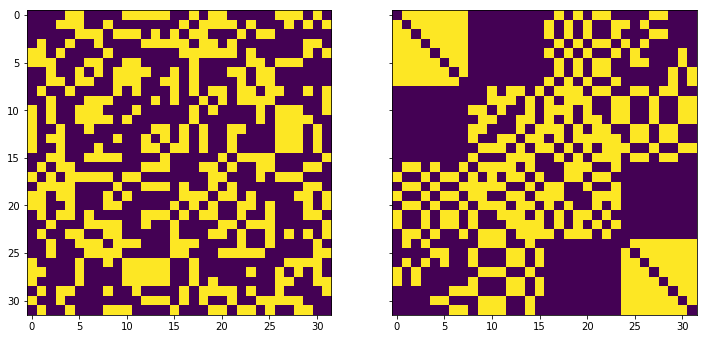

In [3]:
order = z_true.argmax(dim=1).argsort()
A_ordered = A[order,:][:,order]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].imshow(A) 
axs[1].imshow(A_ordered) 
plt.show()

## SBM

First, we try the standard SBM. The default prior distribution in `VIRGMo` is quite flat but for this example we may use a more sharp one. We assume that the sizes of both groups are similar, and the nodes are connected densely within the groups as outside.

In [4]:
def generate_B_prior(inside, outside, num_classes):
    prior = torch.ones([num_classes, num_classes, 2])*torch.tensor(outside)
    for i in range(num_classes):
        prior[i,i] = torch.tensor(inside)
    return prior

In [5]:
sns.set()

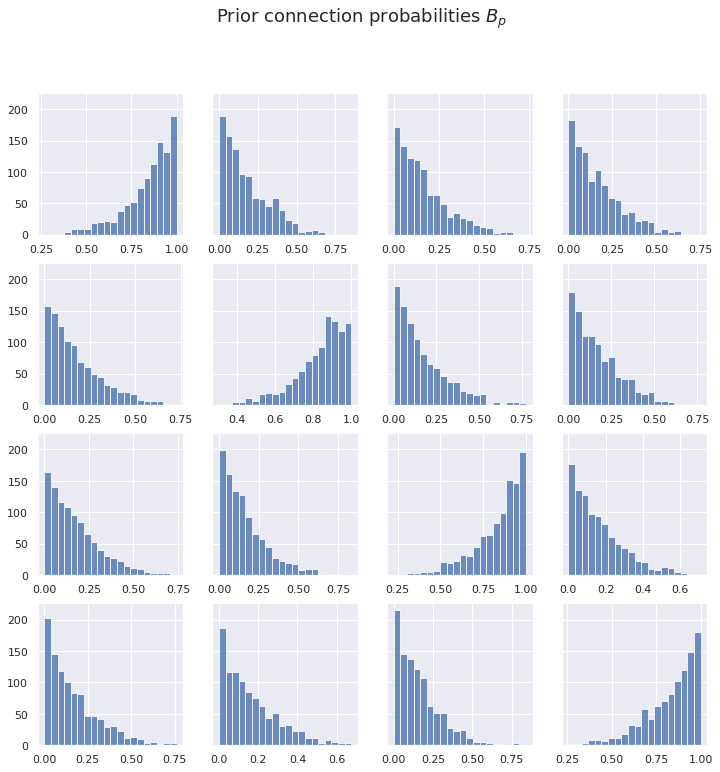

In [6]:
B_p = generate_B_prior(inside=[5., 1],outside=[1, 5.],num_classes=num_classes)

num_samples = 1000
B_samples = Beta(B_p[:,:,0], B_p[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Prior connection probabilities $B_p$', fontsize=18)
plt.show()

In [7]:
theta_p = torch.ones([num_classes])*15
dataloader = DataLoader(EdgesDataset(A), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_SBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':B_p},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None})
trials = 100
vi.multi_train(dataloader, epochs=20, lrs = [0.5, 0.1, 0.01], trials=trials)

>>>>>>> Training iteration #1 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 876.19 | Epoch time 0.18
Epoch 2 | LR: 0.50 | Total loss: 824.96 | Epoch time 0.16
Epoch 3 | LR: 0.50 | Total loss: 805.71 | Epoch time 0.11
Epoch 4 | LR: 0.50 | Total loss: 793.44 | Epoch time 0.15
Epoch 5 | LR: 0.50 | Total loss: 784.89 | Epoch time 0.17
Epoch 6 | LR: 0.50 | Total loss: 778.26 | Epoch time 0.34
Epoch 7 | LR: 0.50 | Total loss: 773.17 | Epoch time 0.16
Epoch 8 | LR: 0.50 | Total loss: 769.25 | Epoch time 0.11
Epoch 9 | LR: 0.50 | Total loss: 765.51 | Epoch time 0.13
Epoch 10 | LR: 0.50 | Total loss: 763.18 | Epoch time 0.14
Epoch 11 | LR: 0.50 | Total loss: 760.59 | Epoch time 0.14
Epoch 12 | LR: 0.50 | Total loss: 758.54 | Epoch time 0.14
Epoch 13 | LR: 0.50 | Total loss: 757.03 | Epoch time 0.29
Epoch 14 | LR: 0.50 | Total loss: 755.54 | Epoch time 0.10
Epoch 15 | LR: 0.50 | Total loss: 754.14 | Epoch time 0.15
Epoch 16 | LR: 0.50 | Total loss: 752.51 | Epoch time 0.25
Ep

Epoch 17 | LR: 0.50 | Total loss: 752.27 | Epoch time 0.15
Epoch 18 | LR: 0.50 | Total loss: 751.19 | Epoch time 0.15
Epoch 19 | LR: 0.50 | Total loss: 750.74 | Epoch time 0.16
Epoch 20 | LR: 0.50 | Total loss: 749.89 | Epoch time 0.16
Epoch 21 | LR: 0.10 | Total loss: 749.11 | Epoch time 0.18
Epoch 22 | LR: 0.10 | Total loss: 748.08 | Epoch time 0.14
Epoch 23 | LR: 0.10 | Total loss: 747.74 | Epoch time 0.11
Epoch 24 | LR: 0.10 | Total loss: 746.88 | Epoch time 0.16
Epoch 25 | LR: 0.10 | Total loss: 746.65 | Epoch time 0.19
Epoch 26 | LR: 0.10 | Total loss: 745.92 | Epoch time 0.16
Epoch 27 | LR: 0.10 | Total loss: 745.16 | Epoch time 0.19
Epoch 28 | LR: 0.10 | Total loss: 745.17 | Epoch time 0.15
Epoch 29 | LR: 0.10 | Total loss: 744.37 | Epoch time 0.17
Epoch 30 | LR: 0.10 | Total loss: 744.73 | Epoch time 0.19
Epoch 31 | LR: 0.10 | Total loss: 744.23 | Epoch time 0.20
Epoch 32 | LR: 0.10 | Total loss: 744.25 | Epoch time 0.16
Epoch 33 | LR: 0.10 | Total loss: 743.90 | Epoch time 0.

Epoch 33 | LR: 0.10 | Total loss: 740.73 | Epoch time 0.11
Epoch 34 | LR: 0.10 | Total loss: 739.96 | Epoch time 0.10
Epoch 35 | LR: 0.10 | Total loss: 739.42 | Epoch time 0.15
Epoch 36 | LR: 0.10 | Total loss: 739.37 | Epoch time 0.18
Epoch 37 | LR: 0.10 | Total loss: 738.56 | Epoch time 0.18
Epoch 38 | LR: 0.10 | Total loss: 738.24 | Epoch time 0.15
Epoch 39 | LR: 0.10 | Total loss: 737.72 | Epoch time 0.17
Epoch 40 | LR: 0.10 | Total loss: 736.90 | Epoch time 0.17
Epoch 41 | LR: 0.01 | Total loss: 737.08 | Epoch time 0.19
Epoch 42 | LR: 0.01 | Total loss: 736.10 | Epoch time 0.18
Epoch 43 | LR: 0.01 | Total loss: 735.77 | Epoch time 0.23
Epoch 44 | LR: 0.01 | Total loss: 735.68 | Epoch time 0.18
Epoch 45 | LR: 0.01 | Total loss: 734.47 | Epoch time 0.19
Epoch 46 | LR: 0.01 | Total loss: 734.64 | Epoch time 0.16
Epoch 47 | LR: 0.01 | Total loss: 734.20 | Epoch time 0.27
Epoch 48 | LR: 0.01 | Total loss: 734.06 | Epoch time 0.24
Epoch 49 | LR: 0.01 | Total loss: 733.74 | Epoch time 0.

Epoch 50 | LR: 0.01 | Total loss: 737.01 | Epoch time 0.21
Epoch 51 | LR: 0.01 | Total loss: 736.33 | Epoch time 0.18
Epoch 52 | LR: 0.01 | Total loss: 736.52 | Epoch time 0.24
Epoch 53 | LR: 0.01 | Total loss: 735.70 | Epoch time 0.31
Epoch 54 | LR: 0.01 | Total loss: 735.39 | Epoch time 0.22
Epoch 55 | LR: 0.01 | Total loss: 735.65 | Epoch time 0.30
Epoch 56 | LR: 0.01 | Total loss: 735.24 | Epoch time 0.26
Epoch 57 | LR: 0.01 | Total loss: 734.47 | Epoch time 0.22
Epoch 58 | LR: 0.01 | Total loss: 734.25 | Epoch time 0.20
Epoch 59 | LR: 0.01 | Total loss: 734.44 | Epoch time 0.27
Epoch 60 | LR: 0.01 | Total loss: 733.76 | Epoch time 0.15
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #8 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 870.16 | Epoch time 0.18
Epoch 2 | LR: 0.50 | Total loss: 821.56 | Epoch time 0.19
Epoch 3 | LR: 0.50 | Total loss: 802.67 | Epoch time 0.16
Epoch 4 | LR: 0.50 | Total loss: 790.55 | Epoch time 0.16
Epoch 5 | LR: 0.50 |

Epoch 6 | LR: 0.50 | Total loss: 778.19 | Epoch time 0.10
Epoch 7 | LR: 0.50 | Total loss: 772.89 | Epoch time 0.11
Epoch 8 | LR: 0.50 | Total loss: 769.19 | Epoch time 0.10
Epoch 9 | LR: 0.50 | Total loss: 765.94 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 762.93 | Epoch time 0.09
Epoch 11 | LR: 0.50 | Total loss: 760.77 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 759.04 | Epoch time 0.10
Epoch 13 | LR: 0.50 | Total loss: 757.07 | Epoch time 0.10
Epoch 14 | LR: 0.50 | Total loss: 755.26 | Epoch time 0.10
Epoch 15 | LR: 0.50 | Total loss: 754.58 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 753.15 | Epoch time 0.09
Epoch 17 | LR: 0.50 | Total loss: 751.77 | Epoch time 0.09
Epoch 18 | LR: 0.50 | Total loss: 750.44 | Epoch time 0.11
Epoch 19 | LR: 0.50 | Total loss: 750.10 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 749.16 | Epoch time 0.08
Epoch 21 | LR: 0.10 | Total loss: 748.32 | Epoch time 0.09
Epoch 22 | LR: 0.10 | Total loss: 748.02 | Epoch time 0.09
E

Epoch 22 | LR: 0.10 | Total loss: 747.55 | Epoch time 0.09
Epoch 23 | LR: 0.10 | Total loss: 746.45 | Epoch time 0.08
Epoch 24 | LR: 0.10 | Total loss: 745.66 | Epoch time 0.08
Epoch 25 | LR: 0.10 | Total loss: 745.22 | Epoch time 0.11
Epoch 26 | LR: 0.10 | Total loss: 744.86 | Epoch time 0.10
Epoch 27 | LR: 0.10 | Total loss: 744.53 | Epoch time 0.10
Epoch 28 | LR: 0.10 | Total loss: 743.03 | Epoch time 0.10
Epoch 29 | LR: 0.10 | Total loss: 742.70 | Epoch time 0.10
Epoch 30 | LR: 0.10 | Total loss: 742.26 | Epoch time 0.10
Epoch 31 | LR: 0.10 | Total loss: 741.96 | Epoch time 0.09
Epoch 32 | LR: 0.10 | Total loss: 741.32 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 740.48 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 740.02 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 739.52 | Epoch time 0.10
Epoch 36 | LR: 0.10 | Total loss: 739.63 | Epoch time 0.15
Epoch 37 | LR: 0.10 | Total loss: 738.87 | Epoch time 0.16
Epoch 38 | LR: 0.10 | Total loss: 738.43 | Epoch time 0.

Epoch 40 | LR: 0.10 | Total loss: 694.10 | Epoch time 0.10
Epoch 41 | LR: 0.01 | Total loss: 690.99 | Epoch time 0.08
Epoch 42 | LR: 0.01 | Total loss: 688.13 | Epoch time 0.08
Epoch 43 | LR: 0.01 | Total loss: 685.66 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 683.30 | Epoch time 0.09
Epoch 45 | LR: 0.01 | Total loss: 681.27 | Epoch time 0.10
Epoch 46 | LR: 0.01 | Total loss: 679.56 | Epoch time 0.10
Epoch 47 | LR: 0.01 | Total loss: 678.03 | Epoch time 0.10
Epoch 48 | LR: 0.01 | Total loss: 676.34 | Epoch time 0.10
Epoch 49 | LR: 0.01 | Total loss: 674.74 | Epoch time 0.11
Epoch 50 | LR: 0.01 | Total loss: 673.59 | Epoch time 0.12
Epoch 51 | LR: 0.01 | Total loss: 673.02 | Epoch time 0.16
Epoch 52 | LR: 0.01 | Total loss: 671.21 | Epoch time 0.12
Epoch 53 | LR: 0.01 | Total loss: 670.19 | Epoch time 0.17
Epoch 54 | LR: 0.01 | Total loss: 669.49 | Epoch time 0.16
Epoch 55 | LR: 0.01 | Total loss: 668.41 | Epoch time 0.12
Epoch 56 | LR: 0.01 | Total loss: 667.41 | Epoch time 0.

Epoch 56 | LR: 0.01 | Total loss: 734.35 | Epoch time 0.15
Epoch 57 | LR: 0.01 | Total loss: 734.10 | Epoch time 0.17
Epoch 58 | LR: 0.01 | Total loss: 734.26 | Epoch time 0.25
Epoch 59 | LR: 0.01 | Total loss: 734.14 | Epoch time 0.17
Epoch 60 | LR: 0.01 | Total loss: 734.00 | Epoch time 0.19
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #17 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 885.28 | Epoch time 0.20
Epoch 2 | LR: 0.50 | Total loss: 831.82 | Epoch time 0.12
Epoch 3 | LR: 0.50 | Total loss: 809.30 | Epoch time 0.11
Epoch 4 | LR: 0.50 | Total loss: 795.53 | Epoch time 0.09
Epoch 5 | LR: 0.50 | Total loss: 785.69 | Epoch time 0.10
Epoch 6 | LR: 0.50 | Total loss: 778.13 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 772.91 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 768.48 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 764.55 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 761.65 | Epoch time 0.09
Epoch 11 | LR: 0.50 | To

Epoch 12 | LR: 0.50 | Total loss: 759.50 | Epoch time 0.15
Epoch 13 | LR: 0.50 | Total loss: 758.36 | Epoch time 0.14
Epoch 14 | LR: 0.50 | Total loss: 755.65 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 754.56 | Epoch time 0.08
Epoch 16 | LR: 0.50 | Total loss: 752.87 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 751.66 | Epoch time 0.10
Epoch 18 | LR: 0.50 | Total loss: 750.26 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 749.51 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 748.85 | Epoch time 0.09
Epoch 21 | LR: 0.10 | Total loss: 748.46 | Epoch time 0.09
Epoch 22 | LR: 0.10 | Total loss: 747.37 | Epoch time 0.09
Epoch 23 | LR: 0.10 | Total loss: 746.84 | Epoch time 0.09
Epoch 24 | LR: 0.10 | Total loss: 745.44 | Epoch time 0.09
Epoch 25 | LR: 0.10 | Total loss: 745.79 | Epoch time 0.08
Epoch 26 | LR: 0.10 | Total loss: 744.84 | Epoch time 0.09
Epoch 27 | LR: 0.10 | Total loss: 744.35 | Epoch time 0.08
Epoch 28 | LR: 0.10 | Total loss: 744.01 | Epoch time 0.

Epoch 29 | LR: 0.10 | Total loss: 743.14 | Epoch time 0.09
Epoch 30 | LR: 0.10 | Total loss: 742.61 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 741.86 | Epoch time 0.08
Epoch 32 | LR: 0.10 | Total loss: 741.17 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 741.08 | Epoch time 0.08
Epoch 34 | LR: 0.10 | Total loss: 740.45 | Epoch time 0.08
Epoch 35 | LR: 0.10 | Total loss: 739.61 | Epoch time 0.09
Epoch 36 | LR: 0.10 | Total loss: 739.08 | Epoch time 0.09
Epoch 37 | LR: 0.10 | Total loss: 738.64 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 738.93 | Epoch time 0.09
Epoch 39 | LR: 0.10 | Total loss: 738.35 | Epoch time 0.08
Epoch 40 | LR: 0.10 | Total loss: 737.61 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 737.16 | Epoch time 0.09
Epoch 42 | LR: 0.01 | Total loss: 736.88 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 736.54 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 736.90 | Epoch time 0.11
Epoch 45 | LR: 0.01 | Total loss: 736.50 | Epoch time 0.

Epoch 47 | LR: 0.01 | Total loss: 735.61 | Epoch time 0.09
Epoch 48 | LR: 0.01 | Total loss: 735.62 | Epoch time 0.09
Epoch 49 | LR: 0.01 | Total loss: 735.14 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 735.01 | Epoch time 0.09
Epoch 51 | LR: 0.01 | Total loss: 735.12 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 734.69 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 734.37 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 734.62 | Epoch time 0.09
Epoch 55 | LR: 0.01 | Total loss: 734.75 | Epoch time 0.09
Epoch 56 | LR: 0.01 | Total loss: 734.21 | Epoch time 0.09
Epoch 57 | LR: 0.01 | Total loss: 734.40 | Epoch time 0.08
Epoch 58 | LR: 0.01 | Total loss: 734.04 | Epoch time 0.09
Epoch 59 | LR: 0.01 | Total loss: 734.01 | Epoch time 0.09
Epoch 60 | LR: 0.01 | Total loss: 733.77 | Epoch time 0.09
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #24 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 863.34 | Epoch time 0.08
Epoch 2 | LR: 0.

Epoch 4 | LR: 0.50 | Total loss: 796.80 | Epoch time 0.09
Epoch 5 | LR: 0.50 | Total loss: 787.54 | Epoch time 0.08
Epoch 6 | LR: 0.50 | Total loss: 780.62 | Epoch time 0.08
Epoch 7 | LR: 0.50 | Total loss: 775.43 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 771.60 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 767.81 | Epoch time 0.08
Epoch 10 | LR: 0.50 | Total loss: 764.98 | Epoch time 0.08
Epoch 11 | LR: 0.50 | Total loss: 762.39 | Epoch time 0.08
Epoch 12 | LR: 0.50 | Total loss: 760.70 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 758.85 | Epoch time 0.09
Epoch 14 | LR: 0.50 | Total loss: 757.63 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 756.01 | Epoch time 0.08
Epoch 16 | LR: 0.50 | Total loss: 754.76 | Epoch time 0.09
Epoch 17 | LR: 0.50 | Total loss: 753.62 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 752.80 | Epoch time 0.08
Epoch 19 | LR: 0.50 | Total loss: 751.78 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 751.04 | Epoch time 0.09
Epo

Epoch 22 | LR: 0.10 | Total loss: 746.41 | Epoch time 0.09
Epoch 23 | LR: 0.10 | Total loss: 745.45 | Epoch time 0.09
Epoch 24 | LR: 0.10 | Total loss: 744.88 | Epoch time 0.08
Epoch 25 | LR: 0.10 | Total loss: 743.90 | Epoch time 0.09
Epoch 26 | LR: 0.10 | Total loss: 743.40 | Epoch time 0.09
Epoch 27 | LR: 0.10 | Total loss: 742.97 | Epoch time 0.08
Epoch 28 | LR: 0.10 | Total loss: 741.63 | Epoch time 0.09
Epoch 29 | LR: 0.10 | Total loss: 741.61 | Epoch time 0.08
Epoch 30 | LR: 0.10 | Total loss: 740.84 | Epoch time 0.11
Epoch 31 | LR: 0.10 | Total loss: 740.32 | Epoch time 0.09
Epoch 32 | LR: 0.10 | Total loss: 739.60 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 739.38 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 738.96 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 737.82 | Epoch time 0.09
Epoch 36 | LR: 0.10 | Total loss: 738.00 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 737.59 | Epoch time 0.09
Epoch 38 | LR: 0.10 | Total loss: 737.50 | Epoch time 0.

Epoch 39 | LR: 0.10 | Total loss: 685.23 | Epoch time 0.09
Epoch 40 | LR: 0.10 | Total loss: 681.23 | Epoch time 0.08
Epoch 41 | LR: 0.01 | Total loss: 677.14 | Epoch time 0.08
Epoch 42 | LR: 0.01 | Total loss: 672.56 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 668.68 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 664.59 | Epoch time 0.08
Epoch 45 | LR: 0.01 | Total loss: 660.68 | Epoch time 0.09
Epoch 46 | LR: 0.01 | Total loss: 657.11 | Epoch time 0.08
Epoch 47 | LR: 0.01 | Total loss: 653.70 | Epoch time 0.08
Epoch 48 | LR: 0.01 | Total loss: 650.44 | Epoch time 0.08
Epoch 49 | LR: 0.01 | Total loss: 648.03 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 645.39 | Epoch time 0.08
Epoch 51 | LR: 0.01 | Total loss: 643.29 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 641.28 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 639.61 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 638.06 | Epoch time 0.08
Epoch 55 | LR: 0.01 | Total loss: 636.84 | Epoch time 0.

Epoch 57 | LR: 0.01 | Total loss: 678.29 | Epoch time 0.08
Epoch 58 | LR: 0.01 | Total loss: 678.05 | Epoch time 0.09
Epoch 59 | LR: 0.01 | Total loss: 676.72 | Epoch time 0.08
Epoch 60 | LR: 0.01 | Total loss: 675.89 | Epoch time 0.08
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #33 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 889.54 | Epoch time 0.08
Epoch 2 | LR: 0.50 | Total loss: 830.97 | Epoch time 0.08
Epoch 3 | LR: 0.50 | Total loss: 808.29 | Epoch time 0.08
Epoch 4 | LR: 0.50 | Total loss: 795.48 | Epoch time 0.09
Epoch 5 | LR: 0.50 | Total loss: 786.45 | Epoch time 0.09
Epoch 6 | LR: 0.50 | Total loss: 779.82 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 774.47 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 770.47 | Epoch time 0.08
Epoch 9 | LR: 0.50 | Total loss: 766.52 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 763.89 | Epoch time 0.08
Epoch 11 | LR: 0.50 | Total loss: 760.73 | Epoch time 0.08
Epoch 12 | LR: 0.50 | To

Epoch 12 | LR: 0.50 | Total loss: 760.04 | Epoch time 0.09
Epoch 13 | LR: 0.50 | Total loss: 757.98 | Epoch time 0.09
Epoch 14 | LR: 0.50 | Total loss: 756.59 | Epoch time 0.08
Epoch 15 | LR: 0.50 | Total loss: 755.11 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 754.11 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 752.99 | Epoch time 0.09
Epoch 18 | LR: 0.50 | Total loss: 751.65 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 750.71 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 750.02 | Epoch time 0.09
Epoch 21 | LR: 0.10 | Total loss: 749.10 | Epoch time 0.08
Epoch 22 | LR: 0.10 | Total loss: 748.12 | Epoch time 0.08
Epoch 23 | LR: 0.10 | Total loss: 747.43 | Epoch time 0.09
Epoch 24 | LR: 0.10 | Total loss: 747.23 | Epoch time 0.09
Epoch 25 | LR: 0.10 | Total loss: 746.49 | Epoch time 0.10
Epoch 26 | LR: 0.10 | Total loss: 745.84 | Epoch time 0.09
Epoch 27 | LR: 0.10 | Total loss: 745.55 | Epoch time 0.09
Epoch 28 | LR: 0.10 | Total loss: 744.63 | Epoch time 0.

Epoch 30 | LR: 0.10 | Total loss: 745.06 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 744.59 | Epoch time 0.09
Epoch 32 | LR: 0.10 | Total loss: 744.13 | Epoch time 0.08
Epoch 33 | LR: 0.10 | Total loss: 743.62 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 742.95 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 741.01 | Epoch time 0.08
Epoch 36 | LR: 0.10 | Total loss: 736.88 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 730.65 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 721.95 | Epoch time 0.08
Epoch 39 | LR: 0.10 | Total loss: 713.72 | Epoch time 0.09
Epoch 40 | LR: 0.10 | Total loss: 705.73 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 698.45 | Epoch time 0.08
Epoch 42 | LR: 0.01 | Total loss: 692.64 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 686.57 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 679.76 | Epoch time 0.10
Epoch 45 | LR: 0.01 | Total loss: 672.65 | Epoch time 0.09
Epoch 46 | LR: 0.01 | Total loss: 664.37 | Epoch time 0.

Epoch 48 | LR: 0.01 | Total loss: 735.80 | Epoch time 0.09
Epoch 49 | LR: 0.01 | Total loss: 735.35 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 735.28 | Epoch time 0.08
Epoch 51 | LR: 0.01 | Total loss: 735.23 | Epoch time 0.08
Epoch 52 | LR: 0.01 | Total loss: 734.75 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 734.82 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 734.61 | Epoch time 0.09
Epoch 55 | LR: 0.01 | Total loss: 734.67 | Epoch time 0.09
Epoch 56 | LR: 0.01 | Total loss: 734.36 | Epoch time 0.09
Epoch 57 | LR: 0.01 | Total loss: 734.12 | Epoch time 0.09
Epoch 58 | LR: 0.01 | Total loss: 734.16 | Epoch time 0.08
Epoch 59 | LR: 0.01 | Total loss: 734.09 | Epoch time 0.08
Epoch 60 | LR: 0.01 | Total loss: 733.72 | Epoch time 0.08
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #40 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 880.63 | Epoch time 0.09
Epoch 2 | LR: 0.50 | Total loss: 828.04 | Epoch time 0.09
Epoch 3 | LR: 0.5

Epoch 5 | LR: 0.50 | Total loss: 789.13 | Epoch time 0.09
Epoch 6 | LR: 0.50 | Total loss: 781.18 | Epoch time 0.08
Epoch 7 | LR: 0.50 | Total loss: 776.69 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 772.28 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 768.47 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 765.47 | Epoch time 0.09
Epoch 11 | LR: 0.50 | Total loss: 763.29 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 760.81 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 758.99 | Epoch time 0.08
Epoch 14 | LR: 0.50 | Total loss: 757.26 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 755.40 | Epoch time 0.08
Epoch 16 | LR: 0.50 | Total loss: 754.70 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 752.36 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 751.86 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 751.11 | Epoch time 0.08
Epoch 20 | LR: 0.50 | Total loss: 749.83 | Epoch time 0.09
Epoch 21 | LR: 0.10 | Total loss: 748.89 | Epoch time 0.08
Ep

Epoch 22 | LR: 0.10 | Total loss: 748.27 | Epoch time 0.09
Epoch 23 | LR: 0.10 | Total loss: 747.74 | Epoch time 0.08
Epoch 24 | LR: 0.10 | Total loss: 747.23 | Epoch time 0.09
Epoch 25 | LR: 0.10 | Total loss: 746.59 | Epoch time 0.09
Epoch 26 | LR: 0.10 | Total loss: 745.79 | Epoch time 0.08
Epoch 27 | LR: 0.10 | Total loss: 745.07 | Epoch time 0.09
Epoch 28 | LR: 0.10 | Total loss: 744.21 | Epoch time 0.09
Epoch 29 | LR: 0.10 | Total loss: 744.15 | Epoch time 0.08
Epoch 30 | LR: 0.10 | Total loss: 743.37 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 743.09 | Epoch time 0.09
Epoch 32 | LR: 0.10 | Total loss: 742.72 | Epoch time 0.08
Epoch 33 | LR: 0.10 | Total loss: 742.34 | Epoch time 0.08
Epoch 34 | LR: 0.10 | Total loss: 741.56 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 740.32 | Epoch time 0.08
Epoch 36 | LR: 0.10 | Total loss: 740.89 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 740.67 | Epoch time 0.09
Epoch 38 | LR: 0.10 | Total loss: 739.90 | Epoch time 0.

Epoch 39 | LR: 0.10 | Total loss: 739.53 | Epoch time 0.09
Epoch 40 | LR: 0.10 | Total loss: 738.79 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 738.13 | Epoch time 0.09
Epoch 42 | LR: 0.01 | Total loss: 738.08 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 738.00 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 737.71 | Epoch time 0.08
Epoch 45 | LR: 0.01 | Total loss: 737.15 | Epoch time 0.09
Epoch 46 | LR: 0.01 | Total loss: 737.08 | Epoch time 0.09
Epoch 47 | LR: 0.01 | Total loss: 737.16 | Epoch time 0.08
Epoch 48 | LR: 0.01 | Total loss: 736.51 | Epoch time 0.09
Epoch 49 | LR: 0.01 | Total loss: 736.48 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 736.11 | Epoch time 0.08
Epoch 51 | LR: 0.01 | Total loss: 736.21 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 735.90 | Epoch time 0.08
Epoch 53 | LR: 0.01 | Total loss: 735.91 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 735.33 | Epoch time 0.09
Epoch 55 | LR: 0.01 | Total loss: 735.17 | Epoch time 0.

Epoch 56 | LR: 0.01 | Total loss: 732.86 | Epoch time 0.09
Epoch 57 | LR: 0.01 | Total loss: 732.48 | Epoch time 0.09
Epoch 58 | LR: 0.01 | Total loss: 732.23 | Epoch time 0.08
Epoch 59 | LR: 0.01 | Total loss: 732.42 | Epoch time 0.09
Epoch 60 | LR: 0.01 | Total loss: 732.41 | Epoch time 0.08
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #49 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 886.40 | Epoch time 0.09
Epoch 2 | LR: 0.50 | Total loss: 833.38 | Epoch time 0.09
Epoch 3 | LR: 0.50 | Total loss: 812.55 | Epoch time 0.09
Epoch 4 | LR: 0.50 | Total loss: 798.83 | Epoch time 0.08
Epoch 5 | LR: 0.50 | Total loss: 788.69 | Epoch time 0.09
Epoch 6 | LR: 0.50 | Total loss: 782.11 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 776.47 | Epoch time 0.08
Epoch 8 | LR: 0.50 | Total loss: 771.79 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 767.64 | Epoch time 0.08
Epoch 10 | LR: 0.50 | Total loss: 765.36 | Epoch time 0.09
Epoch 11 | LR: 0.50 | To

Epoch 11 | LR: 0.50 | Total loss: 761.01 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 758.57 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 757.95 | Epoch time 0.08
Epoch 14 | LR: 0.50 | Total loss: 756.03 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 754.64 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 753.23 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 751.95 | Epoch time 0.09
Epoch 18 | LR: 0.50 | Total loss: 751.37 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 750.58 | Epoch time 0.08
Epoch 20 | LR: 0.50 | Total loss: 749.30 | Epoch time 0.09
Epoch 21 | LR: 0.10 | Total loss: 748.85 | Epoch time 0.08
Epoch 22 | LR: 0.10 | Total loss: 747.73 | Epoch time 0.09
Epoch 23 | LR: 0.10 | Total loss: 747.23 | Epoch time 0.09
Epoch 24 | LR: 0.10 | Total loss: 746.96 | Epoch time 0.08
Epoch 25 | LR: 0.10 | Total loss: 745.94 | Epoch time 0.08
Epoch 26 | LR: 0.10 | Total loss: 745.42 | Epoch time 0.09
Epoch 27 | LR: 0.10 | Total loss: 744.85 | Epoch time 0.

Epoch 28 | LR: 0.10 | Total loss: 719.17 | Epoch time 0.15
Epoch 29 | LR: 0.10 | Total loss: 716.79 | Epoch time 0.15
Epoch 30 | LR: 0.10 | Total loss: 714.79 | Epoch time 0.15
Epoch 31 | LR: 0.10 | Total loss: 712.97 | Epoch time 0.15
Epoch 32 | LR: 0.10 | Total loss: 710.96 | Epoch time 0.15
Epoch 33 | LR: 0.10 | Total loss: 710.04 | Epoch time 0.11
Epoch 34 | LR: 0.10 | Total loss: 708.82 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 707.35 | Epoch time 0.12
Epoch 36 | LR: 0.10 | Total loss: 706.15 | Epoch time 0.15
Epoch 37 | LR: 0.10 | Total loss: 705.43 | Epoch time 0.15
Epoch 38 | LR: 0.10 | Total loss: 704.33 | Epoch time 0.15
Epoch 39 | LR: 0.10 | Total loss: 703.26 | Epoch time 0.16
Epoch 40 | LR: 0.10 | Total loss: 702.62 | Epoch time 0.15
Epoch 41 | LR: 0.01 | Total loss: 701.53 | Epoch time 0.16
Epoch 42 | LR: 0.01 | Total loss: 701.04 | Epoch time 0.15
Epoch 43 | LR: 0.01 | Total loss: 699.89 | Epoch time 0.15
Epoch 44 | LR: 0.01 | Total loss: 699.11 | Epoch time 0.

Epoch 44 | LR: 0.01 | Total loss: 736.22 | Epoch time 0.16
Epoch 45 | LR: 0.01 | Total loss: 735.75 | Epoch time 0.15
Epoch 46 | LR: 0.01 | Total loss: 735.48 | Epoch time 0.15
Epoch 47 | LR: 0.01 | Total loss: 735.43 | Epoch time 0.15
Epoch 48 | LR: 0.01 | Total loss: 733.90 | Epoch time 0.16
Epoch 49 | LR: 0.01 | Total loss: 734.34 | Epoch time 0.16
Epoch 50 | LR: 0.01 | Total loss: 733.94 | Epoch time 0.11
Epoch 51 | LR: 0.01 | Total loss: 734.20 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 733.44 | Epoch time 0.12
Epoch 53 | LR: 0.01 | Total loss: 733.40 | Epoch time 0.14
Epoch 54 | LR: 0.01 | Total loss: 732.90 | Epoch time 0.15
Epoch 55 | LR: 0.01 | Total loss: 732.87 | Epoch time 0.15
Epoch 56 | LR: 0.01 | Total loss: 732.61 | Epoch time 0.16
Epoch 57 | LR: 0.01 | Total loss: 732.52 | Epoch time 0.15
Epoch 58 | LR: 0.01 | Total loss: 732.37 | Epoch time 0.16
Epoch 59 | LR: 0.01 | Total loss: 732.05 | Epoch time 0.16
Epoch 60 | LR: 0.01 | Total loss: 732.15 | Epoch time 0.

Epoch 60 | LR: 0.01 | Total loss: 733.25 | Epoch time 0.09
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #58 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 891.48 | Epoch time 0.08
Epoch 2 | LR: 0.50 | Total loss: 835.84 | Epoch time 0.09
Epoch 3 | LR: 0.50 | Total loss: 813.62 | Epoch time 0.09
Epoch 4 | LR: 0.50 | Total loss: 799.96 | Epoch time 0.08
Epoch 5 | LR: 0.50 | Total loss: 789.89 | Epoch time 0.09
Epoch 6 | LR: 0.50 | Total loss: 781.97 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 776.66 | Epoch time 0.08
Epoch 8 | LR: 0.50 | Total loss: 771.50 | Epoch time 0.08
Epoch 9 | LR: 0.50 | Total loss: 768.20 | Epoch time 0.08
Epoch 10 | LR: 0.50 | Total loss: 765.04 | Epoch time 0.09
Epoch 11 | LR: 0.50 | Total loss: 762.59 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 760.44 | Epoch time 0.09
Epoch 13 | LR: 0.50 | Total loss: 758.97 | Epoch time 0.09
Epoch 14 | LR: 0.50 | Total loss: 756.73 | Epoch time 0.08
Epoch 15 | LR: 0.50 | To

Epoch 15 | LR: 0.50 | Total loss: 756.57 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 754.89 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 753.65 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 753.18 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 751.51 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 750.20 | Epoch time 0.08
Epoch 21 | LR: 0.10 | Total loss: 748.99 | Epoch time 0.09
Epoch 22 | LR: 0.10 | Total loss: 745.82 | Epoch time 0.08
Epoch 23 | LR: 0.10 | Total loss: 740.58 | Epoch time 0.08
Epoch 24 | LR: 0.10 | Total loss: 733.41 | Epoch time 0.08
Epoch 25 | LR: 0.10 | Total loss: 725.31 | Epoch time 0.08
Epoch 26 | LR: 0.10 | Total loss: 717.73 | Epoch time 0.08
Epoch 27 | LR: 0.10 | Total loss: 711.42 | Epoch time 0.09
Epoch 28 | LR: 0.10 | Total loss: 705.95 | Epoch time 0.09
Epoch 29 | LR: 0.10 | Total loss: 700.79 | Epoch time 0.08
Epoch 30 | LR: 0.10 | Total loss: 697.55 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 693.55 | Epoch time 0.

Epoch 33 | LR: 0.10 | Total loss: 701.13 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 697.25 | Epoch time 0.08
Epoch 35 | LR: 0.10 | Total loss: 694.11 | Epoch time 0.08
Epoch 36 | LR: 0.10 | Total loss: 691.21 | Epoch time 0.09
Epoch 37 | LR: 0.10 | Total loss: 688.31 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 686.25 | Epoch time 0.08
Epoch 39 | LR: 0.10 | Total loss: 683.81 | Epoch time 0.09
Epoch 40 | LR: 0.10 | Total loss: 681.70 | Epoch time 0.08
Epoch 41 | LR: 0.01 | Total loss: 680.28 | Epoch time 0.08
Epoch 42 | LR: 0.01 | Total loss: 678.59 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 677.27 | Epoch time 0.08
Epoch 44 | LR: 0.01 | Total loss: 676.00 | Epoch time 0.09
Epoch 45 | LR: 0.01 | Total loss: 674.87 | Epoch time 0.09
Epoch 46 | LR: 0.01 | Total loss: 673.72 | Epoch time 0.08
Epoch 47 | LR: 0.01 | Total loss: 672.31 | Epoch time 0.08
Epoch 48 | LR: 0.01 | Total loss: 671.79 | Epoch time 0.09
Epoch 49 | LR: 0.01 | Total loss: 670.49 | Epoch time 0.

Epoch 51 | LR: 0.01 | Total loss: 671.49 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 671.25 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 670.49 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 669.99 | Epoch time 0.09
Epoch 55 | LR: 0.01 | Total loss: 669.48 | Epoch time 0.09
Epoch 56 | LR: 0.01 | Total loss: 669.69 | Epoch time 0.09
Epoch 57 | LR: 0.01 | Total loss: 668.47 | Epoch time 0.08
Epoch 58 | LR: 0.01 | Total loss: 668.33 | Epoch time 0.08
Epoch 59 | LR: 0.01 | Total loss: 667.81 | Epoch time 0.07
Epoch 60 | LR: 0.01 | Total loss: 667.74 | Epoch time 0.09
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #65 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 892.53 | Epoch time 0.08
Epoch 2 | LR: 0.50 | Total loss: 834.40 | Epoch time 0.08
Epoch 3 | LR: 0.50 | Total loss: 813.38 | Epoch time 0.09
Epoch 4 | LR: 0.50 | Total loss: 799.27 | Epoch time 0.08
Epoch 5 | LR: 0.50 | Total loss: 789.71 | Epoch time 0.08
Epoch 6 | LR: 0.50 |

Epoch 6 | LR: 0.50 | Total loss: 777.18 | Epoch time 0.08
Epoch 7 | LR: 0.50 | Total loss: 771.37 | Epoch time 0.07
Epoch 8 | LR: 0.50 | Total loss: 767.22 | Epoch time 0.08
Epoch 9 | LR: 0.50 | Total loss: 763.56 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 759.94 | Epoch time 0.08
Epoch 11 | LR: 0.50 | Total loss: 758.19 | Epoch time 0.08
Epoch 12 | LR: 0.50 | Total loss: 756.08 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 754.73 | Epoch time 0.08
Epoch 14 | LR: 0.50 | Total loss: 753.08 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 752.34 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 750.74 | Epoch time 0.09
Epoch 17 | LR: 0.50 | Total loss: 749.24 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 748.72 | Epoch time 0.08
Epoch 19 | LR: 0.50 | Total loss: 747.34 | Epoch time 0.08
Epoch 20 | LR: 0.50 | Total loss: 746.82 | Epoch time 0.08
Epoch 21 | LR: 0.10 | Total loss: 746.30 | Epoch time 0.09
Epoch 22 | LR: 0.10 | Total loss: 745.54 | Epoch time 0.08
E

Epoch 24 | LR: 0.10 | Total loss: 746.24 | Epoch time 0.09
Epoch 25 | LR: 0.10 | Total loss: 745.33 | Epoch time 0.08
Epoch 26 | LR: 0.10 | Total loss: 744.75 | Epoch time 0.08
Epoch 27 | LR: 0.10 | Total loss: 744.25 | Epoch time 0.09
Epoch 28 | LR: 0.10 | Total loss: 743.50 | Epoch time 0.08
Epoch 29 | LR: 0.10 | Total loss: 743.70 | Epoch time 0.08
Epoch 30 | LR: 0.10 | Total loss: 742.92 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 742.16 | Epoch time 0.08
Epoch 32 | LR: 0.10 | Total loss: 742.12 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 741.22 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 741.01 | Epoch time 0.08
Epoch 35 | LR: 0.10 | Total loss: 740.45 | Epoch time 0.08
Epoch 36 | LR: 0.10 | Total loss: 739.95 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 739.27 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 738.71 | Epoch time 0.08
Epoch 39 | LR: 0.10 | Total loss: 738.25 | Epoch time 0.08
Epoch 40 | LR: 0.10 | Total loss: 737.85 | Epoch time 0.

Epoch 42 | LR: 0.01 | Total loss: 737.60 | Epoch time 0.09
Epoch 43 | LR: 0.01 | Total loss: 737.44 | Epoch time 0.09
Epoch 44 | LR: 0.01 | Total loss: 737.01 | Epoch time 0.08
Epoch 45 | LR: 0.01 | Total loss: 736.86 | Epoch time 0.08
Epoch 46 | LR: 0.01 | Total loss: 736.34 | Epoch time 0.08
Epoch 47 | LR: 0.01 | Total loss: 736.29 | Epoch time 0.08
Epoch 48 | LR: 0.01 | Total loss: 736.31 | Epoch time 0.09
Epoch 49 | LR: 0.01 | Total loss: 735.86 | Epoch time 0.08
Epoch 50 | LR: 0.01 | Total loss: 735.38 | Epoch time 0.09
Epoch 51 | LR: 0.01 | Total loss: 735.22 | Epoch time 0.09
Epoch 52 | LR: 0.01 | Total loss: 735.16 | Epoch time 0.10
Epoch 53 | LR: 0.01 | Total loss: 735.06 | Epoch time 0.08
Epoch 54 | LR: 0.01 | Total loss: 734.99 | Epoch time 0.10
Epoch 55 | LR: 0.01 | Total loss: 734.79 | Epoch time 0.09
Epoch 56 | LR: 0.01 | Total loss: 734.35 | Epoch time 0.08
Epoch 57 | LR: 0.01 | Total loss: 734.05 | Epoch time 0.09
Epoch 58 | LR: 0.01 | Total loss: 734.72 | Epoch time 0.

Epoch 60 | LR: 0.01 | Total loss: 732.94 | Epoch time 0.09
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #74 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 866.23 | Epoch time 0.08
Epoch 2 | LR: 0.50 | Total loss: 818.46 | Epoch time 0.09
Epoch 3 | LR: 0.50 | Total loss: 800.87 | Epoch time 0.09
Epoch 4 | LR: 0.50 | Total loss: 790.29 | Epoch time 0.08
Epoch 5 | LR: 0.50 | Total loss: 782.07 | Epoch time 0.08
Epoch 6 | LR: 0.50 | Total loss: 776.10 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 771.91 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 767.50 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 764.27 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 761.85 | Epoch time 0.08
Epoch 11 | LR: 0.50 | Total loss: 760.05 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 756.78 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 755.80 | Epoch time 0.09
Epoch 14 | LR: 0.50 | Total loss: 753.84 | Epoch time 0.09
Epoch 15 | LR: 0.50 | To

Epoch 15 | LR: 0.50 | Total loss: 752.76 | Epoch time 0.09
Epoch 16 | LR: 0.50 | Total loss: 751.29 | Epoch time 0.09
Epoch 17 | LR: 0.50 | Total loss: 750.45 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 750.03 | Epoch time 0.09
Epoch 19 | LR: 0.50 | Total loss: 748.40 | Epoch time 0.09
Epoch 20 | LR: 0.50 | Total loss: 747.80 | Epoch time 0.08
Epoch 21 | LR: 0.10 | Total loss: 746.92 | Epoch time 0.08
Epoch 22 | LR: 0.10 | Total loss: 745.95 | Epoch time 0.08
Epoch 23 | LR: 0.10 | Total loss: 745.42 | Epoch time 0.08
Epoch 24 | LR: 0.10 | Total loss: 745.43 | Epoch time 0.09
Epoch 25 | LR: 0.10 | Total loss: 744.36 | Epoch time 0.09
Epoch 26 | LR: 0.10 | Total loss: 743.55 | Epoch time 0.08
Epoch 27 | LR: 0.10 | Total loss: 743.09 | Epoch time 0.08
Epoch 28 | LR: 0.10 | Total loss: 742.52 | Epoch time 0.09
Epoch 29 | LR: 0.10 | Total loss: 742.11 | Epoch time 0.09
Epoch 30 | LR: 0.10 | Total loss: 741.55 | Epoch time 0.08
Epoch 31 | LR: 0.10 | Total loss: 741.24 | Epoch time 0.

Epoch 32 | LR: 0.10 | Total loss: 742.27 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 741.96 | Epoch time 0.08
Epoch 34 | LR: 0.10 | Total loss: 741.56 | Epoch time 0.08
Epoch 35 | LR: 0.10 | Total loss: 741.06 | Epoch time 0.09
Epoch 36 | LR: 0.10 | Total loss: 740.56 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 740.08 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 740.09 | Epoch time 0.08
Epoch 39 | LR: 0.10 | Total loss: 739.45 | Epoch time 0.08
Epoch 40 | LR: 0.10 | Total loss: 739.18 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 738.77 | Epoch time 0.09
Epoch 42 | LR: 0.01 | Total loss: 738.77 | Epoch time 0.08
Epoch 43 | LR: 0.01 | Total loss: 738.56 | Epoch time 0.08
Epoch 44 | LR: 0.01 | Total loss: 738.18 | Epoch time 0.09
Epoch 45 | LR: 0.01 | Total loss: 737.63 | Epoch time 0.08
Epoch 46 | LR: 0.01 | Total loss: 737.97 | Epoch time 0.09
Epoch 47 | LR: 0.01 | Total loss: 737.22 | Epoch time 0.09
Epoch 48 | LR: 0.01 | Total loss: 737.28 | Epoch time 0.

Epoch 50 | LR: 0.01 | Total loss: 736.66 | Epoch time 0.09
Epoch 51 | LR: 0.01 | Total loss: 736.51 | Epoch time 0.08
Epoch 52 | LR: 0.01 | Total loss: 735.85 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 735.04 | Epoch time 0.09
Epoch 54 | LR: 0.01 | Total loss: 733.56 | Epoch time 0.08
Epoch 55 | LR: 0.01 | Total loss: 731.77 | Epoch time 0.08
Epoch 56 | LR: 0.01 | Total loss: 729.59 | Epoch time 0.08
Epoch 57 | LR: 0.01 | Total loss: 725.54 | Epoch time 0.08
Epoch 58 | LR: 0.01 | Total loss: 721.94 | Epoch time 0.09
Epoch 59 | LR: 0.01 | Total loss: 717.08 | Epoch time 0.09
Epoch 60 | LR: 0.01 | Total loss: 712.74 | Epoch time 0.09
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #81 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 867.57 | Epoch time 0.09
Epoch 2 | LR: 0.50 | Total loss: 820.96 | Epoch time 0.09
Epoch 3 | LR: 0.50 | Total loss: 802.00 | Epoch time 0.08
Epoch 4 | LR: 0.50 | Total loss: 790.82 | Epoch time 0.08
Epoch 5 | LR: 0.50 

Epoch 5 | LR: 0.50 | Total loss: 784.77 | Epoch time 0.08
Epoch 6 | LR: 0.50 | Total loss: 778.31 | Epoch time 0.08
Epoch 7 | LR: 0.50 | Total loss: 772.87 | Epoch time 0.08
Epoch 8 | LR: 0.50 | Total loss: 769.14 | Epoch time 0.09
Epoch 9 | LR: 0.50 | Total loss: 765.86 | Epoch time 0.08
Epoch 10 | LR: 0.50 | Total loss: 763.14 | Epoch time 0.08
Epoch 11 | LR: 0.50 | Total loss: 761.06 | Epoch time 0.08
Epoch 12 | LR: 0.50 | Total loss: 758.92 | Epoch time 0.09
Epoch 13 | LR: 0.50 | Total loss: 756.88 | Epoch time 0.08
Epoch 14 | LR: 0.50 | Total loss: 755.14 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 754.86 | Epoch time 0.08
Epoch 16 | LR: 0.50 | Total loss: 754.17 | Epoch time 0.08
Epoch 17 | LR: 0.50 | Total loss: 752.42 | Epoch time 0.08
Epoch 18 | LR: 0.50 | Total loss: 751.75 | Epoch time 0.08
Epoch 19 | LR: 0.50 | Total loss: 750.38 | Epoch time 0.08
Epoch 20 | LR: 0.50 | Total loss: 750.39 | Epoch time 0.08
Epoch 21 | LR: 0.10 | Total loss: 749.96 | Epoch time 0.08
Ep

Epoch 23 | LR: 0.10 | Total loss: 747.69 | Epoch time 0.09
Epoch 24 | LR: 0.10 | Total loss: 746.83 | Epoch time 0.08
Epoch 25 | LR: 0.10 | Total loss: 746.15 | Epoch time 0.08
Epoch 26 | LR: 0.10 | Total loss: 745.62 | Epoch time 0.09
Epoch 27 | LR: 0.10 | Total loss: 745.07 | Epoch time 0.08
Epoch 28 | LR: 0.10 | Total loss: 744.67 | Epoch time 0.08
Epoch 29 | LR: 0.10 | Total loss: 744.23 | Epoch time 0.09
Epoch 30 | LR: 0.10 | Total loss: 743.55 | Epoch time 0.08
Epoch 31 | LR: 0.10 | Total loss: 743.40 | Epoch time 0.08
Epoch 32 | LR: 0.10 | Total loss: 743.10 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 742.21 | Epoch time 0.08
Epoch 34 | LR: 0.10 | Total loss: 742.28 | Epoch time 0.09
Epoch 35 | LR: 0.10 | Total loss: 741.85 | Epoch time 0.09
Epoch 36 | LR: 0.10 | Total loss: 741.37 | Epoch time 0.08
Epoch 37 | LR: 0.10 | Total loss: 740.66 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 740.12 | Epoch time 0.09
Epoch 39 | LR: 0.10 | Total loss: 739.66 | Epoch time 0.

Epoch 40 | LR: 0.10 | Total loss: 740.00 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 740.25 | Epoch time 0.09
Epoch 42 | LR: 0.01 | Total loss: 739.21 | Epoch time 0.08
Epoch 43 | LR: 0.01 | Total loss: 739.12 | Epoch time 0.08
Epoch 44 | LR: 0.01 | Total loss: 738.51 | Epoch time 0.08
Epoch 45 | LR: 0.01 | Total loss: 738.29 | Epoch time 0.09
Epoch 46 | LR: 0.01 | Total loss: 738.19 | Epoch time 0.09
Epoch 47 | LR: 0.01 | Total loss: 737.29 | Epoch time 0.09
Epoch 48 | LR: 0.01 | Total loss: 736.68 | Epoch time 0.08
Epoch 49 | LR: 0.01 | Total loss: 736.62 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 736.12 | Epoch time 0.09
Epoch 51 | LR: 0.01 | Total loss: 735.42 | Epoch time 0.08
Epoch 52 | LR: 0.01 | Total loss: 735.40 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 734.66 | Epoch time 0.09
Epoch 54 | LR: 0.01 | Total loss: 734.18 | Epoch time 0.09
Epoch 55 | LR: 0.01 | Total loss: 733.87 | Epoch time 0.11
Epoch 56 | LR: 0.01 | Total loss: 734.09 | Epoch time 0.

Epoch 58 | LR: 0.01 | Total loss: 655.04 | Epoch time 0.09
Epoch 59 | LR: 0.01 | Total loss: 653.28 | Epoch time 0.08
Epoch 60 | LR: 0.01 | Total loss: 651.44 | Epoch time 0.08
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #90 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 905.36 | Epoch time 0.08
Epoch 2 | LR: 0.50 | Total loss: 841.85 | Epoch time 0.08
Epoch 3 | LR: 0.50 | Total loss: 816.25 | Epoch time 0.08
Epoch 4 | LR: 0.50 | Total loss: 800.84 | Epoch time 0.09
Epoch 5 | LR: 0.50 | Total loss: 789.67 | Epoch time 0.08
Epoch 6 | LR: 0.50 | Total loss: 782.00 | Epoch time 0.08
Epoch 7 | LR: 0.50 | Total loss: 775.57 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 770.58 | Epoch time 0.08
Epoch 9 | LR: 0.50 | Total loss: 766.83 | Epoch time 0.09
Epoch 10 | LR: 0.50 | Total loss: 763.34 | Epoch time 0.09
Epoch 11 | LR: 0.50 | Total loss: 760.49 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 758.28 | Epoch time 0.08
Epoch 13 | LR: 0.50 | To

Epoch 13 | LR: 0.50 | Total loss: 759.75 | Epoch time 0.16
Epoch 14 | LR: 0.50 | Total loss: 758.19 | Epoch time 0.15
Epoch 15 | LR: 0.50 | Total loss: 756.86 | Epoch time 0.17
Epoch 16 | LR: 0.50 | Total loss: 755.49 | Epoch time 0.15
Epoch 17 | LR: 0.50 | Total loss: 754.58 | Epoch time 0.16
Epoch 18 | LR: 0.50 | Total loss: 753.75 | Epoch time 0.15
Epoch 19 | LR: 0.50 | Total loss: 752.56 | Epoch time 0.15
Epoch 20 | LR: 0.50 | Total loss: 752.07 | Epoch time 0.11
Epoch 21 | LR: 0.10 | Total loss: 751.22 | Epoch time 0.09
Epoch 22 | LR: 0.10 | Total loss: 750.28 | Epoch time 0.12
Epoch 23 | LR: 0.10 | Total loss: 750.35 | Epoch time 0.15
Epoch 24 | LR: 0.10 | Total loss: 749.39 | Epoch time 0.15
Epoch 25 | LR: 0.10 | Total loss: 748.56 | Epoch time 0.16
Epoch 26 | LR: 0.10 | Total loss: 747.51 | Epoch time 0.16
Epoch 27 | LR: 0.10 | Total loss: 746.26 | Epoch time 0.15
Epoch 28 | LR: 0.10 | Total loss: 743.96 | Epoch time 0.16
Epoch 29 | LR: 0.10 | Total loss: 739.93 | Epoch time 0.

Epoch 29 | LR: 0.10 | Total loss: 745.23 | Epoch time 0.09
Epoch 30 | LR: 0.10 | Total loss: 745.06 | Epoch time 0.09
Epoch 31 | LR: 0.10 | Total loss: 744.51 | Epoch time 0.09
Epoch 32 | LR: 0.10 | Total loss: 743.82 | Epoch time 0.09
Epoch 33 | LR: 0.10 | Total loss: 743.79 | Epoch time 0.09
Epoch 34 | LR: 0.10 | Total loss: 743.02 | Epoch time 0.08
Epoch 35 | LR: 0.10 | Total loss: 742.52 | Epoch time 0.08
Epoch 36 | LR: 0.10 | Total loss: 742.45 | Epoch time 0.09
Epoch 37 | LR: 0.10 | Total loss: 742.13 | Epoch time 0.08
Epoch 38 | LR: 0.10 | Total loss: 741.95 | Epoch time 0.09
Epoch 39 | LR: 0.10 | Total loss: 741.81 | Epoch time 0.09
Epoch 40 | LR: 0.10 | Total loss: 741.68 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 740.85 | Epoch time 0.09
Epoch 42 | LR: 0.01 | Total loss: 740.50 | Epoch time 0.08
Epoch 43 | LR: 0.01 | Total loss: 740.26 | Epoch time 0.08
Epoch 44 | LR: 0.01 | Total loss: 740.05 | Epoch time 0.09
Epoch 45 | LR: 0.01 | Total loss: 739.90 | Epoch time 0.

Epoch 47 | LR: 0.01 | Total loss: 644.87 | Epoch time 0.09
Epoch 48 | LR: 0.01 | Total loss: 643.83 | Epoch time 0.08
Epoch 49 | LR: 0.01 | Total loss: 643.43 | Epoch time 0.09
Epoch 50 | LR: 0.01 | Total loss: 642.57 | Epoch time 0.09
Epoch 51 | LR: 0.01 | Total loss: 642.23 | Epoch time 0.08
Epoch 52 | LR: 0.01 | Total loss: 641.57 | Epoch time 0.09
Epoch 53 | LR: 0.01 | Total loss: 641.28 | Epoch time 0.09
Epoch 54 | LR: 0.01 | Total loss: 641.32 | Epoch time 0.08
Epoch 55 | LR: 0.01 | Total loss: 640.54 | Epoch time 0.09
Epoch 56 | LR: 0.01 | Total loss: 640.32 | Epoch time 0.09
Epoch 57 | LR: 0.01 | Total loss: 639.95 | Epoch time 0.08
Epoch 58 | LR: 0.01 | Total loss: 640.07 | Epoch time 0.09
Epoch 59 | LR: 0.01 | Total loss: 639.85 | Epoch time 0.09
Epoch 60 | LR: 0.01 | Total loss: 639.61 | Epoch time 0.08
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #97 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.50 | Total loss: 867.90 | Epoch time 0.09
Epoch 2 | LR: 0.

Epoch 2 | LR: 0.50 | Total loss: 820.10 | Epoch time 0.09
Epoch 3 | LR: 0.50 | Total loss: 799.83 | Epoch time 0.08
Epoch 4 | LR: 0.50 | Total loss: 788.09 | Epoch time 0.09
Epoch 5 | LR: 0.50 | Total loss: 779.72 | Epoch time 0.09
Epoch 6 | LR: 0.50 | Total loss: 773.06 | Epoch time 0.09
Epoch 7 | LR: 0.50 | Total loss: 768.06 | Epoch time 0.09
Epoch 8 | LR: 0.50 | Total loss: 764.20 | Epoch time 0.08
Epoch 9 | LR: 0.50 | Total loss: 761.25 | Epoch time 0.08
Epoch 10 | LR: 0.50 | Total loss: 759.39 | Epoch time 0.09
Epoch 11 | LR: 0.50 | Total loss: 756.65 | Epoch time 0.09
Epoch 12 | LR: 0.50 | Total loss: 754.81 | Epoch time 0.08
Epoch 13 | LR: 0.50 | Total loss: 753.44 | Epoch time 0.08
Epoch 14 | LR: 0.50 | Total loss: 751.63 | Epoch time 0.09
Epoch 15 | LR: 0.50 | Total loss: 751.14 | Epoch time 0.08
Epoch 16 | LR: 0.50 | Total loss: 749.83 | Epoch time 0.09
Epoch 17 | LR: 0.50 | Total loss: 749.21 | Epoch time 0.09
Epoch 18 | LR: 0.50 | Total loss: 748.25 | Epoch time 0.09
Epoch

Further, we analyze the trial with the smallest loss.

In [8]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [9]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B = vi.constrained_params()

In [10]:
print('Estimated class probabilities:', vi.multi_results[1][best_trial].numpy())
print('True class probabilities:     ', z_true.sum(dim=0).float().numpy()/32)

Estimated class probabilities: [0.24 0.25 0.25 0.26]
True class probabilities:      [0.25 0.25 0.25 0.25]


Let us plot the network arranging nodes into clusters according to the estimated class assignments.

In [11]:
def plot_clusters(A, num_clusters, labels, colors):
    ''' Plot the network from the adjacency matrix A and arrange 
    the nodes into clusters according to the class assignment.
    '''
    G = nx.Graph(A)
    pos = nx.circular_layout(G)
    angs = np.linspace(0, 2*np.pi, num_clusters+1)
    repos = []
    rad = 3.5     # radius of circle
    for ea in angs:
        if ea > 0:
            repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
    for ea in pos.keys():
        #color = 'black'
        posx = labels[ea]
        pos[ea] += repos[posx]
    plt.figure(figsize=(8,8))
    nx.draw_networkx(G, pos=pos, node_color=colors)
    plt.show()

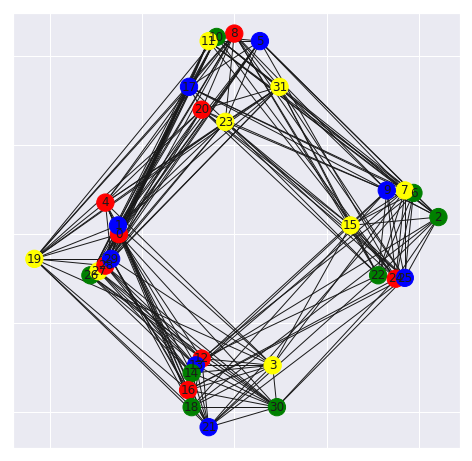

In [13]:
labels = q_eta.argmax(dim=0).clone()
colors = ['red', 'blue', 'green', 'yellow']
labels_perm = permute_classes(labels.float(), [0,2,1,3])  # Permute for better look
plot_clusters(A.numpy(), num_classes, labels_perm.int().numpy(), colors)

But what happend with other trials?

In [14]:
success = 0
for i in range(len(vi.multi_results[0])):
    if vi.class_accuracy(z_true,vi.multi_results[0][i]).item()==1:
        success += 1
print('The number of successfull trials is %d from %d' % (success, trials))

The number of successfull trials is 1 from 100


As you can see, the standard SBM have managed to find the correct class assignment but the success rate is quite low. Note, that the model with the original assignment also has the smallest loss (highest ELBO).

## DCSBM

Next, we try the DCSBM with the same prior as for the SBM. As in the preivious examples we initialize $\delta$ with the observed degree distributions.

In [15]:
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [16]:
dataloader = DataLoader(EdgesDataset(A), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_DCSBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':B_p,
                           'delta_p':None},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None,
                                'deltas':delta_init})
trials = 100
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=trials)

>>>>>>> Training iteration #1 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 885.46 | Epoch time 0.28
Epoch 2 | LR: 0.10 | Total loss: 830.04 | Epoch time 0.14
Epoch 3 | LR: 0.10 | Total loss: 812.13 | Epoch time 0.26
Epoch 4 | LR: 0.10 | Total loss: 810.57 | Epoch time 0.24
Epoch 5 | LR: 0.10 | Total loss: 805.82 | Epoch time 0.31
Epoch 6 | LR: 0.10 | Total loss: 801.38 | Epoch time 0.16
Epoch 7 | LR: 0.10 | Total loss: 797.31 | Epoch time 0.16
Epoch 8 | LR: 0.10 | Total loss: 795.18 | Epoch time 0.13
Epoch 9 | LR: 0.10 | Total loss: 790.09 | Epoch time 0.15
Epoch 10 | LR: 0.10 | Total loss: 794.32 | Epoch time 0.14
Epoch 11 | LR: 0.10 | Total loss: 788.20 | Epoch time 0.17
Epoch 12 | LR: 0.10 | Total loss: 788.73 | Epoch time 0.23
Epoch 13 | LR: 0.10 | Total loss: 788.20 | Epoch time 0.17
Epoch 14 | LR: 0.10 | Total loss: 788.17 | Epoch time 0.19
Epoch 15 | LR: 0.10 | Total loss: 785.10 | Epoch time 0.24
Epoch 16 | LR: 0.10 | Total loss: 778.96 | Epoch time 0.25
Ep

Epoch 16 | LR: 0.10 | Total loss: 785.06 | Epoch time 0.38
Epoch 17 | LR: 0.10 | Total loss: 777.00 | Epoch time 0.40
Epoch 18 | LR: 0.10 | Total loss: 779.20 | Epoch time 0.48
Epoch 19 | LR: 0.10 | Total loss: 778.88 | Epoch time 0.32
Epoch 20 | LR: 0.10 | Total loss: 776.21 | Epoch time 0.42
Epoch 21 | LR: 0.05 | Total loss: 775.88 | Epoch time 0.49
Epoch 22 | LR: 0.05 | Total loss: 767.99 | Epoch time 0.45
Epoch 23 | LR: 0.05 | Total loss: 767.04 | Epoch time 0.39
Epoch 24 | LR: 0.05 | Total loss: 763.61 | Epoch time 0.38
Epoch 25 | LR: 0.05 | Total loss: 758.16 | Epoch time 0.46
Epoch 26 | LR: 0.05 | Total loss: 749.20 | Epoch time 0.48
Epoch 27 | LR: 0.05 | Total loss: 742.25 | Epoch time 0.41
Epoch 28 | LR: 0.05 | Total loss: 738.08 | Epoch time 0.44
Epoch 29 | LR: 0.05 | Total loss: 736.08 | Epoch time 0.40
Epoch 30 | LR: 0.05 | Total loss: 727.78 | Epoch time 0.44
Epoch 31 | LR: 0.05 | Total loss: 724.75 | Epoch time 0.41
Epoch 32 | LR: 0.05 | Total loss: 720.09 | Epoch time 0.

Epoch 32 | LR: 0.05 | Total loss: 703.03 | Epoch time 0.38
Epoch 33 | LR: 0.05 | Total loss: 695.43 | Epoch time 0.32
Epoch 34 | LR: 0.05 | Total loss: 690.40 | Epoch time 0.44
Epoch 35 | LR: 0.05 | Total loss: 688.01 | Epoch time 0.36
Epoch 36 | LR: 0.05 | Total loss: 684.25 | Epoch time 0.28
Epoch 37 | LR: 0.05 | Total loss: 681.67 | Epoch time 0.33
Epoch 38 | LR: 0.05 | Total loss: 674.97 | Epoch time 0.46
Epoch 39 | LR: 0.05 | Total loss: 671.35 | Epoch time 0.28
Epoch 40 | LR: 0.05 | Total loss: 670.19 | Epoch time 0.37
Epoch 41 | LR: 0.01 | Total loss: 664.21 | Epoch time 0.31
Epoch 42 | LR: 0.01 | Total loss: 662.05 | Epoch time 0.44
Epoch 43 | LR: 0.01 | Total loss: 665.27 | Epoch time 0.46
Epoch 44 | LR: 0.01 | Total loss: 659.61 | Epoch time 0.43
Epoch 45 | LR: 0.01 | Total loss: 659.30 | Epoch time 0.42
Epoch 46 | LR: 0.01 | Total loss: 660.21 | Epoch time 0.33
Epoch 47 | LR: 0.01 | Total loss: 657.31 | Epoch time 0.39
Epoch 48 | LR: 0.01 | Total loss: 654.35 | Epoch time 0.

Epoch 48 | LR: 0.01 | Total loss: 720.25 | Epoch time 0.42
Epoch 49 | LR: 0.01 | Total loss: 714.86 | Epoch time 0.36
Epoch 50 | LR: 0.01 | Total loss: 709.14 | Epoch time 0.34
Epoch 51 | LR: 0.01 | Total loss: 706.75 | Epoch time 0.31
Epoch 52 | LR: 0.01 | Total loss: 694.52 | Epoch time 0.33
Epoch 53 | LR: 0.01 | Total loss: 686.41 | Epoch time 0.45
Epoch 54 | LR: 0.01 | Total loss: 669.81 | Epoch time 0.51
Epoch 55 | LR: 0.01 | Total loss: 661.06 | Epoch time 0.45
Epoch 56 | LR: 0.01 | Total loss: 650.05 | Epoch time 0.52
Epoch 57 | LR: 0.01 | Total loss: 639.65 | Epoch time 0.43
Epoch 58 | LR: 0.01 | Total loss: 636.32 | Epoch time 0.43
Epoch 59 | LR: 0.01 | Total loss: 627.03 | Epoch time 0.49
Epoch 60 | LR: 0.01 | Total loss: 624.43 | Epoch time 0.51
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #8 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 867.00 | Epoch time 0.38
Epoch 2 | LR: 0.10 | Total loss: 832.97 | Epoch time 0.31
Epoch 3 | LR: 0.10

Epoch 3 | LR: 0.10 | Total loss: 822.89 | Epoch time 0.28
Epoch 4 | LR: 0.10 | Total loss: 814.16 | Epoch time 0.29
Epoch 5 | LR: 0.10 | Total loss: 801.27 | Epoch time 0.30
Epoch 6 | LR: 0.10 | Total loss: 803.06 | Epoch time 0.33
Epoch 7 | LR: 0.10 | Total loss: 796.82 | Epoch time 0.37
Epoch 8 | LR: 0.10 | Total loss: 793.43 | Epoch time 0.32
Epoch 9 | LR: 0.10 | Total loss: 789.21 | Epoch time 0.33
Epoch 10 | LR: 0.10 | Total loss: 792.52 | Epoch time 0.29
Epoch 11 | LR: 0.10 | Total loss: 789.76 | Epoch time 0.41
Epoch 12 | LR: 0.10 | Total loss: 783.14 | Epoch time 0.40
Epoch 13 | LR: 0.10 | Total loss: 785.95 | Epoch time 0.44
Epoch 14 | LR: 0.10 | Total loss: 779.50 | Epoch time 0.33
Epoch 15 | LR: 0.10 | Total loss: 783.02 | Epoch time 0.35
Epoch 16 | LR: 0.10 | Total loss: 782.24 | Epoch time 0.36
Epoch 17 | LR: 0.10 | Total loss: 779.72 | Epoch time 0.36
Epoch 18 | LR: 0.10 | Total loss: 778.43 | Epoch time 0.39
Epoch 19 | LR: 0.10 | Total loss: 776.68 | Epoch time 0.40
Epoc

Epoch 19 | LR: 0.10 | Total loss: 776.51 | Epoch time 0.33
Epoch 20 | LR: 0.10 | Total loss: 778.30 | Epoch time 0.33
Epoch 21 | LR: 0.05 | Total loss: 776.26 | Epoch time 0.32
Epoch 22 | LR: 0.05 | Total loss: 779.68 | Epoch time 0.45
Epoch 23 | LR: 0.05 | Total loss: 777.36 | Epoch time 0.41
Epoch 24 | LR: 0.05 | Total loss: 771.38 | Epoch time 0.41
Epoch 25 | LR: 0.05 | Total loss: 773.92 | Epoch time 0.33
Epoch 26 | LR: 0.05 | Total loss: 775.02 | Epoch time 0.33
Epoch 27 | LR: 0.05 | Total loss: 772.29 | Epoch time 0.36
Epoch 28 | LR: 0.05 | Total loss: 773.65 | Epoch time 0.51
Epoch 29 | LR: 0.05 | Total loss: 773.33 | Epoch time 0.49
Epoch 30 | LR: 0.05 | Total loss: 770.98 | Epoch time 0.40
Epoch 31 | LR: 0.05 | Total loss: 772.04 | Epoch time 0.39
Epoch 32 | LR: 0.05 | Total loss: 774.19 | Epoch time 0.41
Epoch 33 | LR: 0.05 | Total loss: 772.82 | Epoch time 0.34
Epoch 34 | LR: 0.05 | Total loss: 772.96 | Epoch time 0.32
Epoch 35 | LR: 0.05 | Total loss: 770.74 | Epoch time 0.

Epoch 35 | LR: 0.05 | Total loss: 771.67 | Epoch time 0.46
Epoch 36 | LR: 0.05 | Total loss: 774.76 | Epoch time 0.49
Epoch 37 | LR: 0.05 | Total loss: 768.66 | Epoch time 0.42
Epoch 38 | LR: 0.05 | Total loss: 769.62 | Epoch time 0.38
Epoch 39 | LR: 0.05 | Total loss: 773.33 | Epoch time 0.44
Epoch 40 | LR: 0.05 | Total loss: 768.28 | Epoch time 0.49
Epoch 41 | LR: 0.01 | Total loss: 769.39 | Epoch time 0.32
Epoch 42 | LR: 0.01 | Total loss: 765.41 | Epoch time 0.35
Epoch 43 | LR: 0.01 | Total loss: 764.71 | Epoch time 0.40
Epoch 44 | LR: 0.01 | Total loss: 760.04 | Epoch time 0.34
Epoch 45 | LR: 0.01 | Total loss: 754.69 | Epoch time 0.41
Epoch 46 | LR: 0.01 | Total loss: 748.78 | Epoch time 0.29
Epoch 47 | LR: 0.01 | Total loss: 743.71 | Epoch time 0.31
Epoch 48 | LR: 0.01 | Total loss: 739.86 | Epoch time 0.36
Epoch 49 | LR: 0.01 | Total loss: 736.30 | Epoch time 0.51
Epoch 50 | LR: 0.01 | Total loss: 730.49 | Epoch time 0.32
Epoch 51 | LR: 0.01 | Total loss: 726.14 | Epoch time 0.

Epoch 51 | LR: 0.01 | Total loss: 695.88 | Epoch time 0.40
Epoch 52 | LR: 0.01 | Total loss: 696.18 | Epoch time 0.48
Epoch 53 | LR: 0.01 | Total loss: 692.44 | Epoch time 0.34
Epoch 54 | LR: 0.01 | Total loss: 691.88 | Epoch time 0.44
Epoch 55 | LR: 0.01 | Total loss: 685.31 | Epoch time 0.36
Epoch 56 | LR: 0.01 | Total loss: 689.70 | Epoch time 0.33
Epoch 57 | LR: 0.01 | Total loss: 683.36 | Epoch time 0.45
Epoch 58 | LR: 0.01 | Total loss: 685.84 | Epoch time 0.39
Epoch 59 | LR: 0.01 | Total loss: 680.94 | Epoch time 0.46
Epoch 60 | LR: 0.01 | Total loss: 679.90 | Epoch time 0.34
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #17 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 867.06 | Epoch time 0.33
Epoch 2 | LR: 0.10 | Total loss: 827.75 | Epoch time 0.33
Epoch 3 | LR: 0.10 | Total loss: 818.42 | Epoch time 0.34
Epoch 4 | LR: 0.10 | Total loss: 805.76 | Epoch time 0.32
Epoch 5 | LR: 0.10 | Total loss: 802.18 | Epoch time 0.36
Epoch 6 | LR: 0.10 |

Epoch 6 | LR: 0.10 | Total loss: 795.76 | Epoch time 0.31
Epoch 7 | LR: 0.10 | Total loss: 798.88 | Epoch time 0.20
Epoch 8 | LR: 0.10 | Total loss: 790.65 | Epoch time 0.29
Epoch 9 | LR: 0.10 | Total loss: 789.12 | Epoch time 0.31
Epoch 10 | LR: 0.10 | Total loss: 788.97 | Epoch time 0.29
Epoch 11 | LR: 0.10 | Total loss: 787.62 | Epoch time 0.31
Epoch 12 | LR: 0.10 | Total loss: 787.13 | Epoch time 0.43
Epoch 13 | LR: 0.10 | Total loss: 786.81 | Epoch time 0.25
Epoch 14 | LR: 0.10 | Total loss: 782.09 | Epoch time 0.25
Epoch 15 | LR: 0.10 | Total loss: 782.50 | Epoch time 0.30
Epoch 16 | LR: 0.10 | Total loss: 782.85 | Epoch time 0.32
Epoch 17 | LR: 0.10 | Total loss: 779.48 | Epoch time 0.28
Epoch 18 | LR: 0.10 | Total loss: 778.92 | Epoch time 0.31
Epoch 19 | LR: 0.10 | Total loss: 776.78 | Epoch time 0.30
Epoch 20 | LR: 0.10 | Total loss: 777.96 | Epoch time 0.31
Epoch 21 | LR: 0.05 | Total loss: 777.12 | Epoch time 0.28
Epoch 22 | LR: 0.05 | Total loss: 775.73 | Epoch time 0.25
E

Epoch 22 | LR: 0.05 | Total loss: 774.27 | Epoch time 0.30
Epoch 23 | LR: 0.05 | Total loss: 775.08 | Epoch time 0.26
Epoch 24 | LR: 0.05 | Total loss: 773.24 | Epoch time 0.20
Epoch 25 | LR: 0.05 | Total loss: 774.31 | Epoch time 0.30
Epoch 26 | LR: 0.05 | Total loss: 774.67 | Epoch time 0.28
Epoch 27 | LR: 0.05 | Total loss: 775.09 | Epoch time 0.36
Epoch 28 | LR: 0.05 | Total loss: 771.94 | Epoch time 0.33
Epoch 29 | LR: 0.05 | Total loss: 768.31 | Epoch time 0.29
Epoch 30 | LR: 0.05 | Total loss: 765.92 | Epoch time 0.27
Epoch 31 | LR: 0.05 | Total loss: 764.09 | Epoch time 0.15
Epoch 32 | LR: 0.05 | Total loss: 759.50 | Epoch time 0.19
Epoch 33 | LR: 0.05 | Total loss: 753.39 | Epoch time 0.16
Epoch 34 | LR: 0.05 | Total loss: 750.91 | Epoch time 0.15
Epoch 35 | LR: 0.05 | Total loss: 748.02 | Epoch time 0.16
Epoch 36 | LR: 0.05 | Total loss: 744.75 | Epoch time 0.17
Epoch 37 | LR: 0.05 | Total loss: 739.48 | Epoch time 0.15
Epoch 38 | LR: 0.05 | Total loss: 736.58 | Epoch time 0.

Epoch 38 | LR: 0.05 | Total loss: 774.26 | Epoch time 0.39
Epoch 39 | LR: 0.05 | Total loss: 771.38 | Epoch time 0.28
Epoch 40 | LR: 0.05 | Total loss: 770.83 | Epoch time 0.20
Epoch 41 | LR: 0.01 | Total loss: 773.08 | Epoch time 0.21
Epoch 42 | LR: 0.01 | Total loss: 772.20 | Epoch time 0.17
Epoch 43 | LR: 0.01 | Total loss: 768.94 | Epoch time 0.20
Epoch 44 | LR: 0.01 | Total loss: 772.41 | Epoch time 0.42
Epoch 45 | LR: 0.01 | Total loss: 772.68 | Epoch time 0.32
Epoch 46 | LR: 0.01 | Total loss: 769.87 | Epoch time 0.32
Epoch 47 | LR: 0.01 | Total loss: 767.82 | Epoch time 0.30
Epoch 48 | LR: 0.01 | Total loss: 769.53 | Epoch time 0.17
Epoch 49 | LR: 0.01 | Total loss: 768.05 | Epoch time 0.23
Epoch 50 | LR: 0.01 | Total loss: 768.08 | Epoch time 0.16
Epoch 51 | LR: 0.01 | Total loss: 767.49 | Epoch time 0.16
Epoch 52 | LR: 0.01 | Total loss: 770.00 | Epoch time 0.16
Epoch 53 | LR: 0.01 | Total loss: 773.36 | Epoch time 0.17
Epoch 54 | LR: 0.01 | Total loss: 767.82 | Epoch time 0.

Epoch 54 | LR: 0.01 | Total loss: 657.23 | Epoch time 0.28
Epoch 55 | LR: 0.01 | Total loss: 657.58 | Epoch time 0.38
Epoch 56 | LR: 0.01 | Total loss: 658.31 | Epoch time 0.48
Epoch 57 | LR: 0.01 | Total loss: 654.70 | Epoch time 0.44
Epoch 58 | LR: 0.01 | Total loss: 655.92 | Epoch time 0.50
Epoch 59 | LR: 0.01 | Total loss: 652.95 | Epoch time 0.44
Epoch 60 | LR: 0.01 | Total loss: 649.89 | Epoch time 0.38
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #26 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 868.18 | Epoch time 0.31
Epoch 2 | LR: 0.10 | Total loss: 827.96 | Epoch time 0.50
Epoch 3 | LR: 0.10 | Total loss: 822.07 | Epoch time 0.27
Epoch 4 | LR: 0.10 | Total loss: 808.20 | Epoch time 0.24
Epoch 5 | LR: 0.10 | Total loss: 806.49 | Epoch time 0.29
Epoch 6 | LR: 0.10 | Total loss: 799.49 | Epoch time 0.28
Epoch 7 | LR: 0.10 | Total loss: 794.45 | Epoch time 0.30
Epoch 8 | LR: 0.10 | Total loss: 794.02 | Epoch time 0.42
Epoch 9 | LR: 0.10 | To

Epoch 9 | LR: 0.10 | Total loss: 787.46 | Epoch time 0.45
Epoch 10 | LR: 0.10 | Total loss: 785.37 | Epoch time 0.55
Epoch 11 | LR: 0.10 | Total loss: 787.49 | Epoch time 0.43
Epoch 12 | LR: 0.10 | Total loss: 784.37 | Epoch time 0.27
Epoch 13 | LR: 0.10 | Total loss: 777.71 | Epoch time 0.37
Epoch 14 | LR: 0.10 | Total loss: 778.38 | Epoch time 0.32
Epoch 15 | LR: 0.10 | Total loss: 784.01 | Epoch time 0.30
Epoch 16 | LR: 0.10 | Total loss: 780.08 | Epoch time 0.23
Epoch 17 | LR: 0.10 | Total loss: 775.07 | Epoch time 0.16
Epoch 18 | LR: 0.10 | Total loss: 778.46 | Epoch time 0.16
Epoch 19 | LR: 0.10 | Total loss: 780.43 | Epoch time 0.17
Epoch 20 | LR: 0.10 | Total loss: 778.62 | Epoch time 0.17
Epoch 21 | LR: 0.05 | Total loss: 775.98 | Epoch time 0.16
Epoch 22 | LR: 0.05 | Total loss: 773.54 | Epoch time 0.16
Epoch 23 | LR: 0.05 | Total loss: 772.97 | Epoch time 0.16
Epoch 24 | LR: 0.05 | Total loss: 775.37 | Epoch time 0.16
Epoch 25 | LR: 0.05 | Total loss: 767.95 | Epoch time 0.1

Epoch 25 | LR: 0.05 | Total loss: 764.16 | Epoch time 0.31
Epoch 26 | LR: 0.05 | Total loss: 762.61 | Epoch time 0.42
Epoch 27 | LR: 0.05 | Total loss: 757.19 | Epoch time 0.34
Epoch 28 | LR: 0.05 | Total loss: 746.85 | Epoch time 0.40
Epoch 29 | LR: 0.05 | Total loss: 739.60 | Epoch time 0.37
Epoch 30 | LR: 0.05 | Total loss: 736.30 | Epoch time 0.34
Epoch 31 | LR: 0.05 | Total loss: 734.19 | Epoch time 0.43
Epoch 32 | LR: 0.05 | Total loss: 726.73 | Epoch time 0.44
Epoch 33 | LR: 0.05 | Total loss: 725.17 | Epoch time 0.39
Epoch 34 | LR: 0.05 | Total loss: 717.25 | Epoch time 0.46
Epoch 35 | LR: 0.05 | Total loss: 719.91 | Epoch time 0.40
Epoch 36 | LR: 0.05 | Total loss: 714.66 | Epoch time 0.42
Epoch 37 | LR: 0.05 | Total loss: 708.77 | Epoch time 0.43
Epoch 38 | LR: 0.05 | Total loss: 709.56 | Epoch time 0.39
Epoch 39 | LR: 0.05 | Total loss: 700.80 | Epoch time 0.39
Epoch 40 | LR: 0.05 | Total loss: 695.75 | Epoch time 0.41
Epoch 41 | LR: 0.01 | Total loss: 696.02 | Epoch time 0.

Epoch 41 | LR: 0.01 | Total loss: 726.07 | Epoch time 0.54
Epoch 42 | LR: 0.01 | Total loss: 719.09 | Epoch time 0.44
Epoch 43 | LR: 0.01 | Total loss: 709.80 | Epoch time 0.50
Epoch 44 | LR: 0.01 | Total loss: 706.80 | Epoch time 0.51
Epoch 45 | LR: 0.01 | Total loss: 699.91 | Epoch time 0.53
Epoch 46 | LR: 0.01 | Total loss: 696.12 | Epoch time 0.50
Epoch 47 | LR: 0.01 | Total loss: 689.16 | Epoch time 0.47
Epoch 48 | LR: 0.01 | Total loss: 685.79 | Epoch time 0.59
Epoch 49 | LR: 0.01 | Total loss: 681.08 | Epoch time 0.52
Epoch 50 | LR: 0.01 | Total loss: 679.36 | Epoch time 0.46
Epoch 51 | LR: 0.01 | Total loss: 675.19 | Epoch time 0.52
Epoch 52 | LR: 0.01 | Total loss: 675.21 | Epoch time 0.57
Epoch 53 | LR: 0.01 | Total loss: 671.99 | Epoch time 0.58
Epoch 54 | LR: 0.01 | Total loss: 670.63 | Epoch time 0.46
Epoch 55 | LR: 0.01 | Total loss: 666.75 | Epoch time 0.51
Epoch 56 | LR: 0.01 | Total loss: 667.83 | Epoch time 0.53
Epoch 57 | LR: 0.01 | Total loss: 663.52 | Epoch time 0.

Epoch 57 | LR: 0.01 | Total loss: 667.13 | Epoch time 0.43
Epoch 58 | LR: 0.01 | Total loss: 666.20 | Epoch time 0.34
Epoch 59 | LR: 0.01 | Total loss: 667.67 | Epoch time 0.19
Epoch 60 | LR: 0.01 | Total loss: 664.88 | Epoch time 0.19
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #35 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 867.45 | Epoch time 0.18
Epoch 2 | LR: 0.10 | Total loss: 832.66 | Epoch time 0.18
Epoch 3 | LR: 0.10 | Total loss: 817.76 | Epoch time 0.18
Epoch 4 | LR: 0.10 | Total loss: 812.26 | Epoch time 0.37
Epoch 5 | LR: 0.10 | Total loss: 801.50 | Epoch time 0.30
Epoch 6 | LR: 0.10 | Total loss: 799.04 | Epoch time 0.43
Epoch 7 | LR: 0.10 | Total loss: 794.71 | Epoch time 0.34
Epoch 8 | LR: 0.10 | Total loss: 794.08 | Epoch time 0.32
Epoch 9 | LR: 0.10 | Total loss: 792.66 | Epoch time 0.29
Epoch 10 | LR: 0.10 | Total loss: 790.42 | Epoch time 0.31
Epoch 11 | LR: 0.10 | Total loss: 788.61 | Epoch time 0.21
Epoch 12 | LR: 0.10 | To

Epoch 13 | LR: 0.10 | Total loss: 785.46 | Epoch time 0.18
Epoch 14 | LR: 0.10 | Total loss: 780.91 | Epoch time 0.18
Epoch 15 | LR: 0.10 | Total loss: 779.97 | Epoch time 0.18
Epoch 16 | LR: 0.10 | Total loss: 781.22 | Epoch time 0.17
Epoch 17 | LR: 0.10 | Total loss: 778.88 | Epoch time 0.24
Epoch 18 | LR: 0.10 | Total loss: 781.79 | Epoch time 0.40
Epoch 19 | LR: 0.10 | Total loss: 779.86 | Epoch time 0.43
Epoch 20 | LR: 0.10 | Total loss: 779.43 | Epoch time 0.31
Epoch 21 | LR: 0.05 | Total loss: 778.78 | Epoch time 0.30
Epoch 22 | LR: 0.05 | Total loss: 776.50 | Epoch time 0.27
Epoch 23 | LR: 0.05 | Total loss: 775.80 | Epoch time 0.40
Epoch 24 | LR: 0.05 | Total loss: 775.05 | Epoch time 0.36
Epoch 25 | LR: 0.05 | Total loss: 775.84 | Epoch time 0.31
Epoch 26 | LR: 0.05 | Total loss: 776.16 | Epoch time 0.30
Epoch 27 | LR: 0.05 | Total loss: 774.63 | Epoch time 0.24
Epoch 28 | LR: 0.05 | Total loss: 775.52 | Epoch time 0.22
Epoch 29 | LR: 0.05 | Total loss: 772.78 | Epoch time 0.

Epoch 29 | LR: 0.05 | Total loss: 727.04 | Epoch time 0.26
Epoch 30 | LR: 0.05 | Total loss: 725.36 | Epoch time 0.22
Epoch 31 | LR: 0.05 | Total loss: 719.23 | Epoch time 0.22
Epoch 32 | LR: 0.05 | Total loss: 714.71 | Epoch time 0.27
Epoch 33 | LR: 0.05 | Total loss: 712.18 | Epoch time 0.28
Epoch 34 | LR: 0.05 | Total loss: 709.93 | Epoch time 0.29
Epoch 35 | LR: 0.05 | Total loss: 706.11 | Epoch time 0.29
Epoch 36 | LR: 0.05 | Total loss: 701.74 | Epoch time 0.27
Epoch 37 | LR: 0.05 | Total loss: 700.54 | Epoch time 0.27
Epoch 38 | LR: 0.05 | Total loss: 696.54 | Epoch time 0.24
Epoch 39 | LR: 0.05 | Total loss: 690.75 | Epoch time 0.18
Epoch 40 | LR: 0.05 | Total loss: 690.05 | Epoch time 0.29
Epoch 41 | LR: 0.01 | Total loss: 683.50 | Epoch time 0.26
Epoch 42 | LR: 0.01 | Total loss: 676.46 | Epoch time 0.27
Epoch 43 | LR: 0.01 | Total loss: 678.40 | Epoch time 0.29
Epoch 44 | LR: 0.01 | Total loss: 670.53 | Epoch time 0.30
Epoch 45 | LR: 0.01 | Total loss: 664.50 | Epoch time 0.

Epoch 46 | LR: 0.01 | Total loss: 738.45 | Epoch time 0.16
Epoch 47 | LR: 0.01 | Total loss: 730.53 | Epoch time 0.17
Epoch 48 | LR: 0.01 | Total loss: 722.32 | Epoch time 0.16
Epoch 49 | LR: 0.01 | Total loss: 715.49 | Epoch time 0.16
Epoch 50 | LR: 0.01 | Total loss: 709.40 | Epoch time 0.17
Epoch 51 | LR: 0.01 | Total loss: 703.48 | Epoch time 0.16
Epoch 52 | LR: 0.01 | Total loss: 704.06 | Epoch time 0.16
Epoch 53 | LR: 0.01 | Total loss: 698.13 | Epoch time 0.17
Epoch 54 | LR: 0.01 | Total loss: 693.09 | Epoch time 0.17
Epoch 55 | LR: 0.01 | Total loss: 691.07 | Epoch time 0.17
Epoch 56 | LR: 0.01 | Total loss: 691.75 | Epoch time 0.17
Epoch 57 | LR: 0.01 | Total loss: 689.94 | Epoch time 0.15
Epoch 58 | LR: 0.01 | Total loss: 689.61 | Epoch time 0.17
Epoch 59 | LR: 0.01 | Total loss: 681.09 | Epoch time 0.16
Epoch 60 | LR: 0.01 | Total loss: 683.36 | Epoch time 0.16
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #42 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0

Epoch 2 | LR: 0.10 | Total loss: 831.22 | Epoch time 0.19
Epoch 3 | LR: 0.10 | Total loss: 821.43 | Epoch time 0.20
Epoch 4 | LR: 0.10 | Total loss: 810.94 | Epoch time 0.16
Epoch 5 | LR: 0.10 | Total loss: 803.59 | Epoch time 0.17
Epoch 6 | LR: 0.10 | Total loss: 802.77 | Epoch time 0.16
Epoch 7 | LR: 0.10 | Total loss: 795.91 | Epoch time 0.16
Epoch 8 | LR: 0.10 | Total loss: 791.48 | Epoch time 0.16
Epoch 9 | LR: 0.10 | Total loss: 789.36 | Epoch time 0.17
Epoch 10 | LR: 0.10 | Total loss: 791.01 | Epoch time 0.18
Epoch 11 | LR: 0.10 | Total loss: 788.33 | Epoch time 0.15
Epoch 12 | LR: 0.10 | Total loss: 784.88 | Epoch time 0.17
Epoch 13 | LR: 0.10 | Total loss: 783.82 | Epoch time 0.16
Epoch 14 | LR: 0.10 | Total loss: 783.17 | Epoch time 0.15
Epoch 15 | LR: 0.10 | Total loss: 780.69 | Epoch time 0.17
Epoch 16 | LR: 0.10 | Total loss: 782.41 | Epoch time 0.27
Epoch 17 | LR: 0.10 | Total loss: 778.27 | Epoch time 0.28
Epoch 18 | LR: 0.10 | Total loss: 775.60 | Epoch time 0.27
Epoch

Epoch 18 | LR: 0.10 | Total loss: 775.66 | Epoch time 0.28
Epoch 19 | LR: 0.10 | Total loss: 776.79 | Epoch time 0.29
Epoch 20 | LR: 0.10 | Total loss: 777.87 | Epoch time 0.25
Epoch 21 | LR: 0.05 | Total loss: 775.86 | Epoch time 0.16
Epoch 22 | LR: 0.05 | Total loss: 774.62 | Epoch time 0.28
Epoch 23 | LR: 0.05 | Total loss: 776.93 | Epoch time 0.29
Epoch 24 | LR: 0.05 | Total loss: 777.80 | Epoch time 0.27
Epoch 25 | LR: 0.05 | Total loss: 774.74 | Epoch time 0.26
Epoch 26 | LR: 0.05 | Total loss: 776.05 | Epoch time 0.27
Epoch 27 | LR: 0.05 | Total loss: 774.02 | Epoch time 0.27
Epoch 28 | LR: 0.05 | Total loss: 772.70 | Epoch time 0.28
Epoch 29 | LR: 0.05 | Total loss: 773.55 | Epoch time 0.19
Epoch 30 | LR: 0.05 | Total loss: 774.18 | Epoch time 0.29
Epoch 31 | LR: 0.05 | Total loss: 773.82 | Epoch time 0.32
Epoch 32 | LR: 0.05 | Total loss: 771.64 | Epoch time 0.28
Epoch 33 | LR: 0.05 | Total loss: 772.60 | Epoch time 0.30
Epoch 34 | LR: 0.05 | Total loss: 773.05 | Epoch time 0.

Epoch 35 | LR: 0.05 | Total loss: 772.16 | Epoch time 0.15
Epoch 36 | LR: 0.05 | Total loss: 772.52 | Epoch time 0.17
Epoch 37 | LR: 0.05 | Total loss: 772.46 | Epoch time 0.31
Epoch 38 | LR: 0.05 | Total loss: 770.16 | Epoch time 0.33
Epoch 39 | LR: 0.05 | Total loss: 765.53 | Epoch time 0.16
Epoch 40 | LR: 0.05 | Total loss: 762.23 | Epoch time 0.16
Epoch 41 | LR: 0.01 | Total loss: 755.02 | Epoch time 0.33
Epoch 42 | LR: 0.01 | Total loss: 748.41 | Epoch time 0.33
Epoch 43 | LR: 0.01 | Total loss: 745.54 | Epoch time 0.20
Epoch 44 | LR: 0.01 | Total loss: 740.87 | Epoch time 0.27
Epoch 45 | LR: 0.01 | Total loss: 738.25 | Epoch time 0.30
Epoch 46 | LR: 0.01 | Total loss: 729.32 | Epoch time 0.28
Epoch 47 | LR: 0.01 | Total loss: 726.43 | Epoch time 0.30
Epoch 48 | LR: 0.01 | Total loss: 726.03 | Epoch time 0.36
Epoch 49 | LR: 0.01 | Total loss: 720.98 | Epoch time 0.29
Epoch 50 | LR: 0.01 | Total loss: 719.84 | Epoch time 0.18
Epoch 51 | LR: 0.01 | Total loss: 714.87 | Epoch time 0.

Epoch 51 | LR: 0.01 | Total loss: 714.81 | Epoch time 0.35
Epoch 52 | LR: 0.01 | Total loss: 706.94 | Epoch time 0.40
Epoch 53 | LR: 0.01 | Total loss: 697.37 | Epoch time 0.43
Epoch 54 | LR: 0.01 | Total loss: 684.18 | Epoch time 0.59
Epoch 55 | LR: 0.01 | Total loss: 671.26 | Epoch time 0.57
Epoch 56 | LR: 0.01 | Total loss: 663.90 | Epoch time 0.54
Epoch 57 | LR: 0.01 | Total loss: 651.59 | Epoch time 0.42
Epoch 58 | LR: 0.01 | Total loss: 641.13 | Epoch time 0.46
Epoch 59 | LR: 0.01 | Total loss: 634.39 | Epoch time 0.56
Epoch 60 | LR: 0.01 | Total loss: 630.86 | Epoch time 0.45
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #51 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 872.12 | Epoch time 0.48
Epoch 2 | LR: 0.10 | Total loss: 837.37 | Epoch time 0.48
Epoch 3 | LR: 0.10 | Total loss: 819.69 | Epoch time 0.40
Epoch 4 | LR: 0.10 | Total loss: 811.11 | Epoch time 0.36
Epoch 5 | LR: 0.10 | Total loss: 802.34 | Epoch time 0.43
Epoch 6 | LR: 0.10 |

Epoch 6 | LR: 0.10 | Total loss: 801.55 | Epoch time 0.42
Epoch 7 | LR: 0.10 | Total loss: 796.76 | Epoch time 0.51
Epoch 8 | LR: 0.10 | Total loss: 793.13 | Epoch time 0.45
Epoch 9 | LR: 0.10 | Total loss: 790.58 | Epoch time 0.50
Epoch 10 | LR: 0.10 | Total loss: 787.61 | Epoch time 0.40
Epoch 11 | LR: 0.10 | Total loss: 785.79 | Epoch time 0.29
Epoch 12 | LR: 0.10 | Total loss: 784.29 | Epoch time 0.37
Epoch 13 | LR: 0.10 | Total loss: 786.26 | Epoch time 0.51
Epoch 14 | LR: 0.10 | Total loss: 782.82 | Epoch time 0.47
Epoch 15 | LR: 0.10 | Total loss: 782.34 | Epoch time 0.32
Epoch 16 | LR: 0.10 | Total loss: 778.54 | Epoch time 0.28
Epoch 17 | LR: 0.10 | Total loss: 773.35 | Epoch time 0.26
Epoch 18 | LR: 0.10 | Total loss: 773.11 | Epoch time 0.37
Epoch 19 | LR: 0.10 | Total loss: 770.80 | Epoch time 0.30
Epoch 20 | LR: 0.10 | Total loss: 769.00 | Epoch time 0.45
Epoch 21 | LR: 0.05 | Total loss: 760.79 | Epoch time 0.39
Epoch 22 | LR: 0.05 | Total loss: 753.19 | Epoch time 0.19
E

Epoch 22 | LR: 0.05 | Total loss: 776.69 | Epoch time 0.16
Epoch 23 | LR: 0.05 | Total loss: 774.35 | Epoch time 0.17
Epoch 24 | LR: 0.05 | Total loss: 776.05 | Epoch time 0.16
Epoch 25 | LR: 0.05 | Total loss: 774.69 | Epoch time 0.16
Epoch 26 | LR: 0.05 | Total loss: 776.74 | Epoch time 0.15
Epoch 27 | LR: 0.05 | Total loss: 775.32 | Epoch time 0.16
Epoch 28 | LR: 0.05 | Total loss: 773.33 | Epoch time 0.15
Epoch 29 | LR: 0.05 | Total loss: 772.74 | Epoch time 0.16
Epoch 30 | LR: 0.05 | Total loss: 775.17 | Epoch time 0.17
Epoch 31 | LR: 0.05 | Total loss: 773.32 | Epoch time 0.16
Epoch 32 | LR: 0.05 | Total loss: 772.06 | Epoch time 0.16
Epoch 33 | LR: 0.05 | Total loss: 770.36 | Epoch time 0.15
Epoch 34 | LR: 0.05 | Total loss: 772.68 | Epoch time 0.16
Epoch 35 | LR: 0.05 | Total loss: 773.19 | Epoch time 0.16
Epoch 36 | LR: 0.05 | Total loss: 773.65 | Epoch time 0.16
Epoch 37 | LR: 0.05 | Total loss: 771.61 | Epoch time 0.17
Epoch 38 | LR: 0.05 | Total loss: 772.75 | Epoch time 0.

Epoch 38 | LR: 0.05 | Total loss: 765.73 | Epoch time 0.16
Epoch 39 | LR: 0.05 | Total loss: 762.04 | Epoch time 0.26
Epoch 40 | LR: 0.05 | Total loss: 755.62 | Epoch time 0.16
Epoch 41 | LR: 0.01 | Total loss: 751.40 | Epoch time 0.17
Epoch 42 | LR: 0.01 | Total loss: 745.43 | Epoch time 0.16
Epoch 43 | LR: 0.01 | Total loss: 734.69 | Epoch time 0.29
Epoch 44 | LR: 0.01 | Total loss: 734.67 | Epoch time 0.30
Epoch 45 | LR: 0.01 | Total loss: 727.68 | Epoch time 0.29
Epoch 46 | LR: 0.01 | Total loss: 721.33 | Epoch time 0.29
Epoch 47 | LR: 0.01 | Total loss: 717.77 | Epoch time 0.19
Epoch 48 | LR: 0.01 | Total loss: 712.26 | Epoch time 0.31
Epoch 49 | LR: 0.01 | Total loss: 707.48 | Epoch time 0.35
Epoch 50 | LR: 0.01 | Total loss: 705.31 | Epoch time 0.40
Epoch 51 | LR: 0.01 | Total loss: 700.01 | Epoch time 0.38
Epoch 52 | LR: 0.01 | Total loss: 698.56 | Epoch time 0.34
Epoch 53 | LR: 0.01 | Total loss: 693.01 | Epoch time 0.28
Epoch 54 | LR: 0.01 | Total loss: 690.84 | Epoch time 0.

Epoch 55 | LR: 0.01 | Total loss: 637.84 | Epoch time 0.18
Epoch 56 | LR: 0.01 | Total loss: 632.65 | Epoch time 0.16
Epoch 57 | LR: 0.01 | Total loss: 629.98 | Epoch time 0.17
Epoch 58 | LR: 0.01 | Total loss: 621.97 | Epoch time 0.17
Epoch 59 | LR: 0.01 | Total loss: 621.06 | Epoch time 0.17
Epoch 60 | LR: 0.01 | Total loss: 614.79 | Epoch time 0.31
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #60 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 864.22 | Epoch time 0.34
Epoch 2 | LR: 0.10 | Total loss: 833.43 | Epoch time 0.17
Epoch 3 | LR: 0.10 | Total loss: 818.11 | Epoch time 0.18
Epoch 4 | LR: 0.10 | Total loss: 807.30 | Epoch time 0.17
Epoch 5 | LR: 0.10 | Total loss: 804.26 | Epoch time 0.17
Epoch 6 | LR: 0.10 | Total loss: 795.11 | Epoch time 0.19
Epoch 7 | LR: 0.10 | Total loss: 793.71 | Epoch time 0.16
Epoch 8 | LR: 0.10 | Total loss: 791.86 | Epoch time 0.17
Epoch 9 | LR: 0.10 | Total loss: 789.32 | Epoch time 0.17
Epoch 10 | LR: 0.10 | To

Epoch 10 | LR: 0.10 | Total loss: 787.21 | Epoch time 0.30
Epoch 11 | LR: 0.10 | Total loss: 788.60 | Epoch time 0.19
Epoch 12 | LR: 0.10 | Total loss: 788.93 | Epoch time 0.30
Epoch 13 | LR: 0.10 | Total loss: 784.99 | Epoch time 0.27
Epoch 14 | LR: 0.10 | Total loss: 781.40 | Epoch time 0.30
Epoch 15 | LR: 0.10 | Total loss: 782.96 | Epoch time 0.25
Epoch 16 | LR: 0.10 | Total loss: 782.64 | Epoch time 0.27
Epoch 17 | LR: 0.10 | Total loss: 778.69 | Epoch time 0.31
Epoch 18 | LR: 0.10 | Total loss: 780.98 | Epoch time 0.33
Epoch 19 | LR: 0.10 | Total loss: 778.70 | Epoch time 0.31
Epoch 20 | LR: 0.10 | Total loss: 774.46 | Epoch time 0.33
Epoch 21 | LR: 0.05 | Total loss: 776.74 | Epoch time 0.29
Epoch 22 | LR: 0.05 | Total loss: 776.24 | Epoch time 0.27
Epoch 23 | LR: 0.05 | Total loss: 776.55 | Epoch time 0.20
Epoch 24 | LR: 0.05 | Total loss: 777.44 | Epoch time 0.31
Epoch 25 | LR: 0.05 | Total loss: 771.88 | Epoch time 0.32
Epoch 26 | LR: 0.05 | Total loss: 778.72 | Epoch time 0.

Epoch 26 | LR: 0.05 | Total loss: 773.16 | Epoch time 0.30
Epoch 27 | LR: 0.05 | Total loss: 772.90 | Epoch time 0.30
Epoch 28 | LR: 0.05 | Total loss: 770.49 | Epoch time 0.29
Epoch 29 | LR: 0.05 | Total loss: 774.62 | Epoch time 0.30
Epoch 30 | LR: 0.05 | Total loss: 771.26 | Epoch time 0.24
Epoch 31 | LR: 0.05 | Total loss: 769.84 | Epoch time 0.19
Epoch 32 | LR: 0.05 | Total loss: 768.94 | Epoch time 0.28
Epoch 33 | LR: 0.05 | Total loss: 775.53 | Epoch time 0.21
Epoch 34 | LR: 0.05 | Total loss: 771.67 | Epoch time 0.16
Epoch 35 | LR: 0.05 | Total loss: 769.96 | Epoch time 0.28
Epoch 36 | LR: 0.05 | Total loss: 772.14 | Epoch time 0.29
Epoch 37 | LR: 0.05 | Total loss: 772.46 | Epoch time 0.31
Epoch 38 | LR: 0.05 | Total loss: 771.32 | Epoch time 0.32
Epoch 39 | LR: 0.05 | Total loss: 769.32 | Epoch time 0.23
Epoch 40 | LR: 0.05 | Total loss: 769.31 | Epoch time 0.27
Epoch 41 | LR: 0.01 | Total loss: 768.86 | Epoch time 0.32
Epoch 42 | LR: 0.01 | Total loss: 767.59 | Epoch time 0.

Epoch 42 | LR: 0.01 | Total loss: 691.05 | Epoch time 0.29
Epoch 43 | LR: 0.01 | Total loss: 684.66 | Epoch time 0.39
Epoch 44 | LR: 0.01 | Total loss: 682.30 | Epoch time 0.53
Epoch 45 | LR: 0.01 | Total loss: 678.38 | Epoch time 0.33
Epoch 46 | LR: 0.01 | Total loss: 678.76 | Epoch time 0.28
Epoch 47 | LR: 0.01 | Total loss: 678.84 | Epoch time 0.20
Epoch 48 | LR: 0.01 | Total loss: 675.15 | Epoch time 0.30
Epoch 49 | LR: 0.01 | Total loss: 667.93 | Epoch time 0.43
Epoch 50 | LR: 0.01 | Total loss: 673.50 | Epoch time 0.39
Epoch 51 | LR: 0.01 | Total loss: 669.06 | Epoch time 0.31
Epoch 52 | LR: 0.01 | Total loss: 665.92 | Epoch time 0.29
Epoch 53 | LR: 0.01 | Total loss: 661.90 | Epoch time 0.30
Epoch 54 | LR: 0.01 | Total loss: 664.57 | Epoch time 0.37
Epoch 55 | LR: 0.01 | Total loss: 665.09 | Epoch time 0.21
Epoch 56 | LR: 0.01 | Total loss: 663.36 | Epoch time 0.19
Epoch 57 | LR: 0.01 | Total loss: 659.46 | Epoch time 0.18
Epoch 58 | LR: 0.01 | Total loss: 662.18 | Epoch time 0.

Epoch 59 | LR: 0.01 | Total loss: 769.48 | Epoch time 0.18
Epoch 60 | LR: 0.01 | Total loss: 766.67 | Epoch time 0.17
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #69 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 864.41 | Epoch time 0.24
Epoch 2 | LR: 0.10 | Total loss: 823.38 | Epoch time 0.27
Epoch 3 | LR: 0.10 | Total loss: 810.75 | Epoch time 0.31
Epoch 4 | LR: 0.10 | Total loss: 809.81 | Epoch time 0.23
Epoch 5 | LR: 0.10 | Total loss: 801.68 | Epoch time 0.22
Epoch 6 | LR: 0.10 | Total loss: 795.89 | Epoch time 0.32
Epoch 7 | LR: 0.10 | Total loss: 789.92 | Epoch time 0.33
Epoch 8 | LR: 0.10 | Total loss: 792.38 | Epoch time 0.32
Epoch 9 | LR: 0.10 | Total loss: 787.32 | Epoch time 0.30
Epoch 10 | LR: 0.10 | Total loss: 788.98 | Epoch time 0.31
Epoch 11 | LR: 0.10 | Total loss: 786.52 | Epoch time 0.28
Epoch 12 | LR: 0.10 | Total loss: 780.91 | Epoch time 0.21
Epoch 13 | LR: 0.10 | Total loss: 783.58 | Epoch time 0.29
Epoch 14 | LR: 0.10 | To

Epoch 14 | LR: 0.10 | Total loss: 783.25 | Epoch time 0.18
Epoch 15 | LR: 0.10 | Total loss: 784.82 | Epoch time 0.25
Epoch 16 | LR: 0.10 | Total loss: 781.18 | Epoch time 0.30
Epoch 17 | LR: 0.10 | Total loss: 778.60 | Epoch time 0.28
Epoch 18 | LR: 0.10 | Total loss: 779.54 | Epoch time 0.22
Epoch 19 | LR: 0.10 | Total loss: 780.38 | Epoch time 0.18
Epoch 20 | LR: 0.10 | Total loss: 779.48 | Epoch time 0.17
Epoch 21 | LR: 0.05 | Total loss: 777.34 | Epoch time 0.18
Epoch 22 | LR: 0.05 | Total loss: 775.36 | Epoch time 0.17
Epoch 23 | LR: 0.05 | Total loss: 780.38 | Epoch time 0.17
Epoch 24 | LR: 0.05 | Total loss: 775.65 | Epoch time 0.19
Epoch 25 | LR: 0.05 | Total loss: 774.10 | Epoch time 0.17
Epoch 26 | LR: 0.05 | Total loss: 773.47 | Epoch time 0.18
Epoch 27 | LR: 0.05 | Total loss: 773.35 | Epoch time 0.16
Epoch 28 | LR: 0.05 | Total loss: 776.54 | Epoch time 0.18
Epoch 29 | LR: 0.05 | Total loss: 772.77 | Epoch time 0.33
Epoch 30 | LR: 0.05 | Total loss: 773.91 | Epoch time 0.

Epoch 31 | LR: 0.05 | Total loss: 762.23 | Epoch time 0.20
Epoch 32 | LR: 0.05 | Total loss: 758.72 | Epoch time 0.18
Epoch 33 | LR: 0.05 | Total loss: 752.38 | Epoch time 0.18
Epoch 34 | LR: 0.05 | Total loss: 749.05 | Epoch time 0.17
Epoch 35 | LR: 0.05 | Total loss: 743.23 | Epoch time 0.19
Epoch 36 | LR: 0.05 | Total loss: 737.24 | Epoch time 0.17
Epoch 37 | LR: 0.05 | Total loss: 736.50 | Epoch time 0.17
Epoch 38 | LR: 0.05 | Total loss: 731.83 | Epoch time 0.18
Epoch 39 | LR: 0.05 | Total loss: 726.87 | Epoch time 0.18
Epoch 40 | LR: 0.05 | Total loss: 726.68 | Epoch time 0.18
Epoch 41 | LR: 0.01 | Total loss: 723.76 | Epoch time 0.17
Epoch 42 | LR: 0.01 | Total loss: 720.25 | Epoch time 0.18
Epoch 43 | LR: 0.01 | Total loss: 716.80 | Epoch time 0.18
Epoch 44 | LR: 0.01 | Total loss: 711.09 | Epoch time 0.17
Epoch 45 | LR: 0.01 | Total loss: 709.20 | Epoch time 0.18
Epoch 46 | LR: 0.01 | Total loss: 705.68 | Epoch time 0.19
Epoch 47 | LR: 0.01 | Total loss: 707.04 | Epoch time 0.

Epoch 48 | LR: 0.01 | Total loss: 769.69 | Epoch time 0.18
Epoch 49 | LR: 0.01 | Total loss: 768.05 | Epoch time 0.18
Epoch 50 | LR: 0.01 | Total loss: 769.00 | Epoch time 0.18
Epoch 51 | LR: 0.01 | Total loss: 767.85 | Epoch time 0.18
Epoch 52 | LR: 0.01 | Total loss: 763.06 | Epoch time 0.18
Epoch 53 | LR: 0.01 | Total loss: 763.72 | Epoch time 0.17
Epoch 54 | LR: 0.01 | Total loss: 758.01 | Epoch time 0.18
Epoch 55 | LR: 0.01 | Total loss: 752.81 | Epoch time 0.19
Epoch 56 | LR: 0.01 | Total loss: 745.72 | Epoch time 0.18
Epoch 57 | LR: 0.01 | Total loss: 738.10 | Epoch time 0.17
Epoch 58 | LR: 0.01 | Total loss: 731.88 | Epoch time 0.17
Epoch 59 | LR: 0.01 | Total loss: 725.40 | Epoch time 0.18
Epoch 60 | LR: 0.01 | Total loss: 722.30 | Epoch time 0.18
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #76 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 860.90 | Epoch time 0.18
Epoch 2 | LR: 0.10 | Total loss: 830.23 | Epoch time 0.17
Epoch 3 | LR: 0.1

Epoch 4 | LR: 0.10 | Total loss: 807.89 | Epoch time 0.17
Epoch 5 | LR: 0.10 | Total loss: 799.79 | Epoch time 0.17
Epoch 6 | LR: 0.10 | Total loss: 796.92 | Epoch time 0.17
Epoch 7 | LR: 0.10 | Total loss: 789.95 | Epoch time 0.17
Epoch 8 | LR: 0.10 | Total loss: 790.43 | Epoch time 0.17
Epoch 9 | LR: 0.10 | Total loss: 789.07 | Epoch time 0.16
Epoch 10 | LR: 0.10 | Total loss: 791.41 | Epoch time 0.18
Epoch 11 | LR: 0.10 | Total loss: 786.11 | Epoch time 0.17
Epoch 12 | LR: 0.10 | Total loss: 785.62 | Epoch time 0.19
Epoch 13 | LR: 0.10 | Total loss: 782.46 | Epoch time 0.32
Epoch 14 | LR: 0.10 | Total loss: 779.50 | Epoch time 0.34
Epoch 15 | LR: 0.10 | Total loss: 777.23 | Epoch time 0.23
Epoch 16 | LR: 0.10 | Total loss: 780.67 | Epoch time 0.17
Epoch 17 | LR: 0.10 | Total loss: 778.09 | Epoch time 0.18
Epoch 18 | LR: 0.10 | Total loss: 779.72 | Epoch time 0.18
Epoch 19 | LR: 0.10 | Total loss: 777.95 | Epoch time 0.17
Epoch 20 | LR: 0.10 | Total loss: 775.85 | Epoch time 0.17
Epo

Epoch 20 | LR: 0.10 | Total loss: 776.09 | Epoch time 0.16
Epoch 21 | LR: 0.05 | Total loss: 774.79 | Epoch time 0.24
Epoch 22 | LR: 0.05 | Total loss: 771.57 | Epoch time 0.28
Epoch 23 | LR: 0.05 | Total loss: 777.60 | Epoch time 0.30
Epoch 24 | LR: 0.05 | Total loss: 776.07 | Epoch time 0.47
Epoch 25 | LR: 0.05 | Total loss: 774.46 | Epoch time 0.47
Epoch 26 | LR: 0.05 | Total loss: 774.95 | Epoch time 0.56
Epoch 27 | LR: 0.05 | Total loss: 772.27 | Epoch time 0.43
Epoch 28 | LR: 0.05 | Total loss: 774.61 | Epoch time 0.53
Epoch 29 | LR: 0.05 | Total loss: 770.38 | Epoch time 0.69
Epoch 30 | LR: 0.05 | Total loss: 773.20 | Epoch time 0.49
Epoch 31 | LR: 0.05 | Total loss: 773.85 | Epoch time 0.60
Epoch 32 | LR: 0.05 | Total loss: 772.56 | Epoch time 0.79
Epoch 33 | LR: 0.05 | Total loss: 772.56 | Epoch time 0.47
Epoch 34 | LR: 0.05 | Total loss: 771.77 | Epoch time 0.39
Epoch 35 | LR: 0.05 | Total loss: 770.60 | Epoch time 0.56
Epoch 36 | LR: 0.05 | Total loss: 770.30 | Epoch time 0.

Epoch 37 | LR: 0.05 | Total loss: 769.54 | Epoch time 0.15
Epoch 38 | LR: 0.05 | Total loss: 770.73 | Epoch time 0.16
Epoch 39 | LR: 0.05 | Total loss: 771.40 | Epoch time 0.16
Epoch 40 | LR: 0.05 | Total loss: 773.98 | Epoch time 0.14
Epoch 41 | LR: 0.01 | Total loss: 769.44 | Epoch time 0.16
Epoch 42 | LR: 0.01 | Total loss: 772.06 | Epoch time 0.15
Epoch 43 | LR: 0.01 | Total loss: 770.51 | Epoch time 0.16
Epoch 44 | LR: 0.01 | Total loss: 769.00 | Epoch time 0.15
Epoch 45 | LR: 0.01 | Total loss: 768.57 | Epoch time 0.15
Epoch 46 | LR: 0.01 | Total loss: 766.42 | Epoch time 0.15
Epoch 47 | LR: 0.01 | Total loss: 765.35 | Epoch time 0.15
Epoch 48 | LR: 0.01 | Total loss: 760.71 | Epoch time 0.15
Epoch 49 | LR: 0.01 | Total loss: 752.81 | Epoch time 0.16
Epoch 50 | LR: 0.01 | Total loss: 746.23 | Epoch time 0.15
Epoch 51 | LR: 0.01 | Total loss: 738.35 | Epoch time 0.16
Epoch 52 | LR: 0.01 | Total loss: 731.43 | Epoch time 0.15
Epoch 53 | LR: 0.01 | Total loss: 726.50 | Epoch time 0.

Epoch 54 | LR: 0.01 | Total loss: 674.03 | Epoch time 0.15
Epoch 55 | LR: 0.01 | Total loss: 670.29 | Epoch time 0.14
Epoch 56 | LR: 0.01 | Total loss: 669.20 | Epoch time 0.15
Epoch 57 | LR: 0.01 | Total loss: 666.39 | Epoch time 0.15
Epoch 58 | LR: 0.01 | Total loss: 667.35 | Epoch time 0.16
Epoch 59 | LR: 0.01 | Total loss: 665.43 | Epoch time 0.14
Epoch 60 | LR: 0.01 | Total loss: 661.67 | Epoch time 0.15
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #85 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 861.19 | Epoch time 0.14
Epoch 2 | LR: 0.10 | Total loss: 832.22 | Epoch time 0.16
Epoch 3 | LR: 0.10 | Total loss: 816.06 | Epoch time 0.15
Epoch 4 | LR: 0.10 | Total loss: 808.90 | Epoch time 0.16
Epoch 5 | LR: 0.10 | Total loss: 804.33 | Epoch time 0.15
Epoch 6 | LR: 0.10 | Total loss: 805.09 | Epoch time 0.15
Epoch 7 | LR: 0.10 | Total loss: 801.49 | Epoch time 0.15
Epoch 8 | LR: 0.10 | Total loss: 791.22 | Epoch time 0.15
Epoch 9 | LR: 0.10 | To

Epoch 9 | LR: 0.10 | Total loss: 789.71 | Epoch time 0.27
Epoch 10 | LR: 0.10 | Total loss: 782.70 | Epoch time 0.26
Epoch 11 | LR: 0.10 | Total loss: 786.71 | Epoch time 0.24
Epoch 12 | LR: 0.10 | Total loss: 782.91 | Epoch time 0.19
Epoch 13 | LR: 0.10 | Total loss: 782.85 | Epoch time 0.27
Epoch 14 | LR: 0.10 | Total loss: 784.20 | Epoch time 0.29
Epoch 15 | LR: 0.10 | Total loss: 781.79 | Epoch time 0.23
Epoch 16 | LR: 0.10 | Total loss: 782.75 | Epoch time 0.16
Epoch 17 | LR: 0.10 | Total loss: 779.91 | Epoch time 0.16
Epoch 18 | LR: 0.10 | Total loss: 776.07 | Epoch time 0.16
Epoch 19 | LR: 0.10 | Total loss: 782.04 | Epoch time 0.15
Epoch 20 | LR: 0.10 | Total loss: 777.96 | Epoch time 0.16
Epoch 21 | LR: 0.05 | Total loss: 777.36 | Epoch time 0.15
Epoch 22 | LR: 0.05 | Total loss: 780.14 | Epoch time 0.16
Epoch 23 | LR: 0.05 | Total loss: 776.05 | Epoch time 0.16
Epoch 24 | LR: 0.05 | Total loss: 776.97 | Epoch time 0.15
Epoch 25 | LR: 0.05 | Total loss: 778.21 | Epoch time 0.1

Epoch 25 | LR: 0.05 | Total loss: 773.13 | Epoch time 0.27
Epoch 26 | LR: 0.05 | Total loss: 776.11 | Epoch time 0.27
Epoch 27 | LR: 0.05 | Total loss: 774.64 | Epoch time 0.28
Epoch 28 | LR: 0.05 | Total loss: 775.58 | Epoch time 0.24
Epoch 29 | LR: 0.05 | Total loss: 774.52 | Epoch time 0.18
Epoch 30 | LR: 0.05 | Total loss: 772.47 | Epoch time 0.27
Epoch 31 | LR: 0.05 | Total loss: 772.44 | Epoch time 0.29
Epoch 32 | LR: 0.05 | Total loss: 770.38 | Epoch time 0.26
Epoch 33 | LR: 0.05 | Total loss: 769.09 | Epoch time 0.25
Epoch 34 | LR: 0.05 | Total loss: 772.25 | Epoch time 0.28
Epoch 35 | LR: 0.05 | Total loss: 768.76 | Epoch time 0.29
Epoch 36 | LR: 0.05 | Total loss: 769.08 | Epoch time 0.28
Epoch 37 | LR: 0.05 | Total loss: 764.10 | Epoch time 0.17
Epoch 38 | LR: 0.05 | Total loss: 761.74 | Epoch time 0.23
Epoch 39 | LR: 0.05 | Total loss: 755.39 | Epoch time 0.26
Epoch 40 | LR: 0.05 | Total loss: 749.00 | Epoch time 0.27
Epoch 41 | LR: 0.01 | Total loss: 746.05 | Epoch time 0.

Epoch 41 | LR: 0.01 | Total loss: 721.64 | Epoch time 0.15
Epoch 42 | LR: 0.01 | Total loss: 716.66 | Epoch time 0.15
Epoch 43 | LR: 0.01 | Total loss: 716.06 | Epoch time 0.15
Epoch 44 | LR: 0.01 | Total loss: 712.84 | Epoch time 0.17
Epoch 45 | LR: 0.01 | Total loss: 710.95 | Epoch time 0.15
Epoch 46 | LR: 0.01 | Total loss: 705.89 | Epoch time 0.15
Epoch 47 | LR: 0.01 | Total loss: 709.26 | Epoch time 0.15
Epoch 48 | LR: 0.01 | Total loss: 707.50 | Epoch time 0.15
Epoch 49 | LR: 0.01 | Total loss: 706.58 | Epoch time 0.15
Epoch 50 | LR: 0.01 | Total loss: 703.44 | Epoch time 0.15
Epoch 51 | LR: 0.01 | Total loss: 699.41 | Epoch time 0.16
Epoch 52 | LR: 0.01 | Total loss: 696.68 | Epoch time 0.15
Epoch 53 | LR: 0.01 | Total loss: 699.36 | Epoch time 0.15
Epoch 54 | LR: 0.01 | Total loss: 696.26 | Epoch time 0.15
Epoch 55 | LR: 0.01 | Total loss: 693.96 | Epoch time 0.15
Epoch 56 | LR: 0.01 | Total loss: 693.88 | Epoch time 0.14
Epoch 57 | LR: 0.01 | Total loss: 690.76 | Epoch time 0.

Epoch 57 | LR: 0.01 | Total loss: 611.60 | Epoch time 0.15
Epoch 58 | LR: 0.01 | Total loss: 606.21 | Epoch time 0.15
Epoch 59 | LR: 0.01 | Total loss: 606.94 | Epoch time 0.15
Epoch 60 | LR: 0.01 | Total loss: 603.24 | Epoch time 0.15
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #94 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 872.07 | Epoch time 0.15
Epoch 2 | LR: 0.10 | Total loss: 831.16 | Epoch time 0.16
Epoch 3 | LR: 0.10 | Total loss: 820.38 | Epoch time 0.16
Epoch 4 | LR: 0.10 | Total loss: 810.88 | Epoch time 0.15
Epoch 5 | LR: 0.10 | Total loss: 803.55 | Epoch time 0.15
Epoch 6 | LR: 0.10 | Total loss: 799.24 | Epoch time 0.15
Epoch 7 | LR: 0.10 | Total loss: 791.35 | Epoch time 0.15
Epoch 8 | LR: 0.10 | Total loss: 795.29 | Epoch time 0.15
Epoch 9 | LR: 0.10 | Total loss: 792.25 | Epoch time 0.16
Epoch 10 | LR: 0.10 | Total loss: 786.42 | Epoch time 0.15
Epoch 11 | LR: 0.10 | Total loss: 785.76 | Epoch time 0.15
Epoch 12 | LR: 0.10 | To

Epoch 13 | LR: 0.10 | Total loss: 786.29 | Epoch time 0.17
Epoch 14 | LR: 0.10 | Total loss: 782.82 | Epoch time 0.16
Epoch 15 | LR: 0.10 | Total loss: 779.97 | Epoch time 0.16
Epoch 16 | LR: 0.10 | Total loss: 781.16 | Epoch time 0.15
Epoch 17 | LR: 0.10 | Total loss: 781.42 | Epoch time 0.16
Epoch 18 | LR: 0.10 | Total loss: 780.55 | Epoch time 0.15
Epoch 19 | LR: 0.10 | Total loss: 779.45 | Epoch time 0.16
Epoch 20 | LR: 0.10 | Total loss: 776.14 | Epoch time 0.15
Epoch 21 | LR: 0.05 | Total loss: 772.10 | Epoch time 0.16
Epoch 22 | LR: 0.05 | Total loss: 771.76 | Epoch time 0.14
Epoch 23 | LR: 0.05 | Total loss: 763.31 | Epoch time 0.16
Epoch 24 | LR: 0.05 | Total loss: 759.91 | Epoch time 0.15
Epoch 25 | LR: 0.05 | Total loss: 753.54 | Epoch time 0.16
Epoch 26 | LR: 0.05 | Total loss: 749.61 | Epoch time 0.15
Epoch 27 | LR: 0.05 | Total loss: 743.04 | Epoch time 0.15
Epoch 28 | LR: 0.05 | Total loss: 740.74 | Epoch time 0.15
Epoch 29 | LR: 0.05 | Total loss: 735.86 | Epoch time 0.

Epoch 29 | LR: 0.05 | Total loss: 774.51 | Epoch time 0.15
Epoch 30 | LR: 0.05 | Total loss: 775.07 | Epoch time 0.15
Epoch 31 | LR: 0.05 | Total loss: 772.22 | Epoch time 0.16
Epoch 32 | LR: 0.05 | Total loss: 769.57 | Epoch time 0.15
Epoch 33 | LR: 0.05 | Total loss: 770.72 | Epoch time 0.16
Epoch 34 | LR: 0.05 | Total loss: 767.35 | Epoch time 0.15
Epoch 35 | LR: 0.05 | Total loss: 766.86 | Epoch time 0.16
Epoch 36 | LR: 0.05 | Total loss: 763.63 | Epoch time 0.15
Epoch 37 | LR: 0.05 | Total loss: 757.43 | Epoch time 0.17
Epoch 38 | LR: 0.05 | Total loss: 750.55 | Epoch time 0.15
Epoch 39 | LR: 0.05 | Total loss: 749.49 | Epoch time 0.16
Epoch 40 | LR: 0.05 | Total loss: 745.55 | Epoch time 0.15
Epoch 41 | LR: 0.01 | Total loss: 739.64 | Epoch time 0.15
Epoch 42 | LR: 0.01 | Total loss: 735.22 | Epoch time 0.15
Epoch 43 | LR: 0.01 | Total loss: 730.67 | Epoch time 0.15
Epoch 44 | LR: 0.01 | Total loss: 729.94 | Epoch time 0.16
Epoch 45 | LR: 0.01 | Total loss: 724.42 | Epoch time 0.

Epoch 45 | LR: 0.01 | Total loss: 741.23 | Epoch time 0.25
Epoch 46 | LR: 0.01 | Total loss: 737.27 | Epoch time 0.29
Epoch 47 | LR: 0.01 | Total loss: 730.39 | Epoch time 0.21
Epoch 48 | LR: 0.01 | Total loss: 722.72 | Epoch time 0.22
Epoch 49 | LR: 0.01 | Total loss: 720.56 | Epoch time 0.26
Epoch 50 | LR: 0.01 | Total loss: 708.79 | Epoch time 0.29
Epoch 51 | LR: 0.01 | Total loss: 698.68 | Epoch time 0.27
Epoch 52 | LR: 0.01 | Total loss: 691.30 | Epoch time 0.27
Epoch 53 | LR: 0.01 | Total loss: 678.80 | Epoch time 0.27
Epoch 54 | LR: 0.01 | Total loss: 668.30 | Epoch time 0.18
Epoch 55 | LR: 0.01 | Total loss: 656.90 | Epoch time 0.18
Epoch 56 | LR: 0.01 | Total loss: 646.88 | Epoch time 0.16
Epoch 57 | LR: 0.01 | Total loss: 641.89 | Epoch time 0.16
Epoch 58 | LR: 0.01 | Total loss: 633.49 | Epoch time 0.15
Epoch 59 | LR: 0.01 | Total loss: 628.68 | Epoch time 0.15
Epoch 60 | LR: 0.01 | Total loss: 622.07 | Epoch time 0.16
>>>>>>>>>>>> Training is finished.



In [17]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [18]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [19]:
print('Estimated class probabilities:', vi.multi_results[1][best_trial].numpy())
print('True class probabilities:     ', z_true.sum(dim=0).float().numpy()/32)

Estimated class probabilities: [0.25 0.25 0.25 0.25]
True class probabilities:      [0.25 0.25 0.25 0.25]


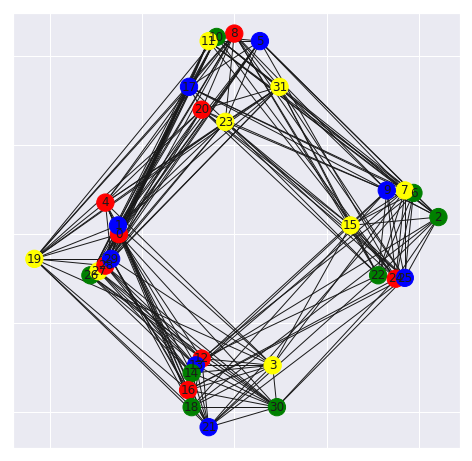

In [24]:
labels = q_eta.argmax(dim=0).clone()
colors = ['red', 'blue', 'green', 'yellow']
labels_perm = permute_classes(labels.float(), [1,0,2,3])  # Permute for better look
plot_clusters(A.numpy(), num_classes, labels_perm.int().numpy(), colors)

In [25]:
success = 0
for i in range(len(vi.multi_results[0])):
    if vi.class_accuracy(z_true,vi.multi_results[0][i]).item()==1:
        success += 1
print('The number of successfull trials is %d from %d' % (success, trials))

The number of successfull trials is 18 from 100


The DCSBM also has found the correct class assignment and it was more successfull comparing the number of trials as the SBM. Further, we may inspect the estimated $\theta$ and $B$ distributions in the best trial.

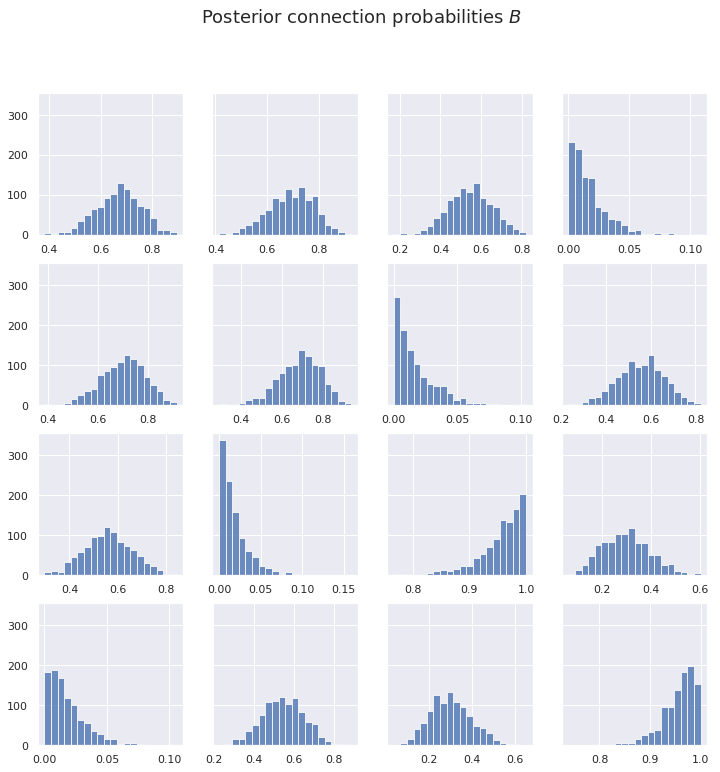

In [26]:
q_B_perm = q_B.detach() #[permutation,:,:][:,permutation,:]
num_samples = 1000
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
plt.show()